In [1]:
!pip install numpy
!pip install pandas
!pip install plotly
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from tensorflow import keras
# from tensorflow.keras import optimizers
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras.models import Sequential, Model
#from tensorflow.python.keras.layers.convolutional import Conv1D, MaxPooling1D
#from tensorflow.python.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
# from keras.layers import TimeDistributed
# from tensorflow.keras.layers import Dense, Conv1D , MaxPooling1D , LSTM, TimeDistributed, Flatten, GRU, RepeatVector
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
# import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff


from plotly.offline import init_notebook_mode, iplot

# matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
# from tensorflow.compat.v1 import set_random_seed
# from numpy.random import seed
# set_random_seed(1)
# seed(1)




Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np, pandas as pd
print(np.__version__)
print(pd.__version__)


1.26.4
1.4.4


In [3]:
pd.set_option('display.max_columns', None)

train = pd.read_csv('SC_DL/train.csv', parse_dates=['date'])

train.shape

#Time period of the train dataset
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


<div class="alert alert-block alert-info"> <b> Data Cleaning and Pre-processing</b> </div>


In [4]:
# Ensure 'date' is datetime
train['date'] = pd.to_datetime(train['date'], infer_datetime_format=True)

# # Split into training and test sets (without dropping 'date')
# test = train[train['date'] > '2017-08-01'].copy()
# train = train[train['date'] <= '2017-07-31'].copy()

# Add date-based features to training data
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.isocalendar().week
train['dayofweek'] = train['date'].dt.dayofweek
train['weekday'] = train['date'].dt.weekday
train['dayofyear'] = train['date'].dt.dayofyear
train['quarter'] = train['date'].dt.quarter

# Add aggregated features
train['daily_avg'] = train.groupby(['item', 'store', 'dayofweek'])['sales'].transform('mean')
train['monthly_avg'] = train.groupby(['item', 'store', 'month'])['sales'].transform('mean')
train['mean_store_item_month'] = train.groupby(['month', 'item', 'store'])['sales'].transform('mean')

# Optionally store the aggregated summary (not used in training)
daily_avg = train.groupby(['item', 'store', 'dayofweek'])['sales'].mean().reset_index()
monthly_avg = train.groupby(['item', 'store', 'month'])['sales'].mean().reset_index()
mean_store_item_month = train.groupby(['month', 'item', 'store'])['sales'].mean().reset_index()
train['week'] = train['week'].astype('int32')
# Check data types
print(train.dtypes)


date                     datetime64[ns]
store                             int64
item                              int64
sales                             int64
year                              int64
month                             int64
day                               int64
week                              int32
dayofweek                         int64
weekday                           int64
dayofyear                         int64
quarter                           int64
daily_avg                       float64
monthly_avg                     float64
mean_store_item_month           float64
dtype: object


In [5]:
train.head()

,date,store,item,sales,year,month,day,week,dayofweek,weekday,dayofyear,quarter,daily_avg,monthly_avg,mean_store_item_month
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1,1,18.168582,13.709677,13.709677
1,2013-01-02,1,1,11,2013,1,2,1,2,2,2,1,18.793103,13.709677,13.709677
2,2013-01-03,1,1,14,2013,1,3,1,3,3,3,1,19.452107,13.709677,13.709677
3,2013-01-04,1,1,13,2013,1,4,1,4,4,4,1,21.015326,13.709677,13.709677
4,2013-01-05,1,1,10,2013,1,5,1,5,5,5,1,22.973180,13.709677,13.709677


In [6]:
#making a copy of the training data to use to for further processing
train_v2 = train.copy()
train.head()

,date,store,item,sales,year,month,day,week,dayofweek,weekday,dayofyear,quarter,daily_avg,monthly_avg,mean_store_item_month
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1,1,18.168582,13.709677,13.709677
1,2013-01-02,1,1,11,2013,1,2,1,2,2,2,1,18.793103,13.709677,13.709677
2,2013-01-03,1,1,14,2013,1,3,1,3,3,3,1,19.452107,13.709677,13.709677
3,2013-01-04,1,1,13,2013,1,4,1,4,4,4,1,21.015326,13.709677,13.709677
4,2013-01-05,1,1,10,2013,1,5,1,5,5,5,1,22.973180,13.709677,13.709677


In [7]:
# Create New DataFrame of Specific column by DataFrame.assign() method.
sales_df = pd.DataFrame().assign(sales=train_v2['sales'])

def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Drop rows with NaN values
#     if dropnan:
#         agg.dropna(inplace=True)
    return agg

#introducing look-back feature
window = 29
lag = 30
sales_series = series_to_supervised(sales_df, window=window, lag=lag)
sales_series = sales_series.drop('sales(t)', axis=1)
sales_series = sales_series.drop('sales(t+30)', axis=1)
sales_series.shape

(913000, 29)

In [8]:
#merging training dataset with the sales_series created above with the look-back feature
train_v2 = pd.concat([train_v2, sales_series], axis=1)
#replacing NaN values with 0
train_v2 = train_v2.replace(np.nan,0)
train_v2.head()

,date,store,item,sales,year,month,day,week,dayofweek,weekday,dayofyear,quarter,daily_avg,monthly_avg,mean_store_item_month,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),sales(t-19),sales(t-18),sales(t-17),sales(t-16),sales(t-15),sales(t-14),sales(t-13),sales(t-12),sales(t-11),sales(t-10),sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1)
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1,1,18.168582,13.709677,13.709677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-02,1,1,11,2013,1,2,1,2,2,2,1,18.793103,13.709677,13.709677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0
2,2013-01-03,1,1,14,2013,1,3,1,3,3,3,1,19.452107,13.709677,13.709677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,11.0
3,2013-01-04,1,1,13,2013,1,4,1,4,4,4,1,21.015326,13.709677,13.709677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,11.0,14.0
4,2013-01-05,1,1,10,2013,1,5,1,5,5,5,1,22.973180,13.709677,13.709677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,11.0,14.0,13.0


In [9]:
#feature set specific to machine learning models
train['is_month_start'] = train['date'].dt.is_month_start
train['is_month_end'] =train['date'].dt.is_month_end
train['is_quarter_start'] = train['date'].dt.is_quarter_start
train['is_quarter_end'] = train['date'].dt.is_quarter_end
train['is_year_start'] = train['date'].dt.is_year_start
train['is_year_end'] = train['date'].dt.is_year_end

#Create mask for boolean values for train dataset
train['is_month_start'] = train['is_month_start'].replace({True: 1, False: 0})
train['is_month_end'] = train['is_month_end'].replace({True: 1, False: 0})
train['is_quarter_start'] = train['is_quarter_start'].replace({True: 1, False: 0})
train['is_quarter_end'] = train['is_quarter_end'].replace({True: 1, False: 0})
train['is_year_start'] = train['is_year_start'].replace({True: 1, False: 0})
train['is_year_end'] = train['is_year_end'].replace({True: 1, False: 0})

#convert float to int
train['daily_avg']=train['daily_avg'].astype(np.int64)
train['monthly_avg']=train['monthly_avg'].astype(np.int64)
train['mean_store_item_month']=train['mean_store_item_month'].astype(np.int64)
train.dtypes

date                     datetime64[ns]
store                             int64
item                              int64
sales                             int64
year                              int64
month                             int64
day                               int64
week                              int32
dayofweek                         int64
weekday                           int64
dayofyear                         int64
quarter                           int64
daily_avg                         int64
monthly_avg                       int64
mean_store_item_month             int64
is_month_start                    int64
is_month_end                      int64
is_quarter_start                  int64
is_quarter_end                    int64
is_year_start                     int64
is_year_end                       int64
dtype: object

<div class="alert alert-block alert-info"> <b>Exploratory Data Analysis</b> </div>


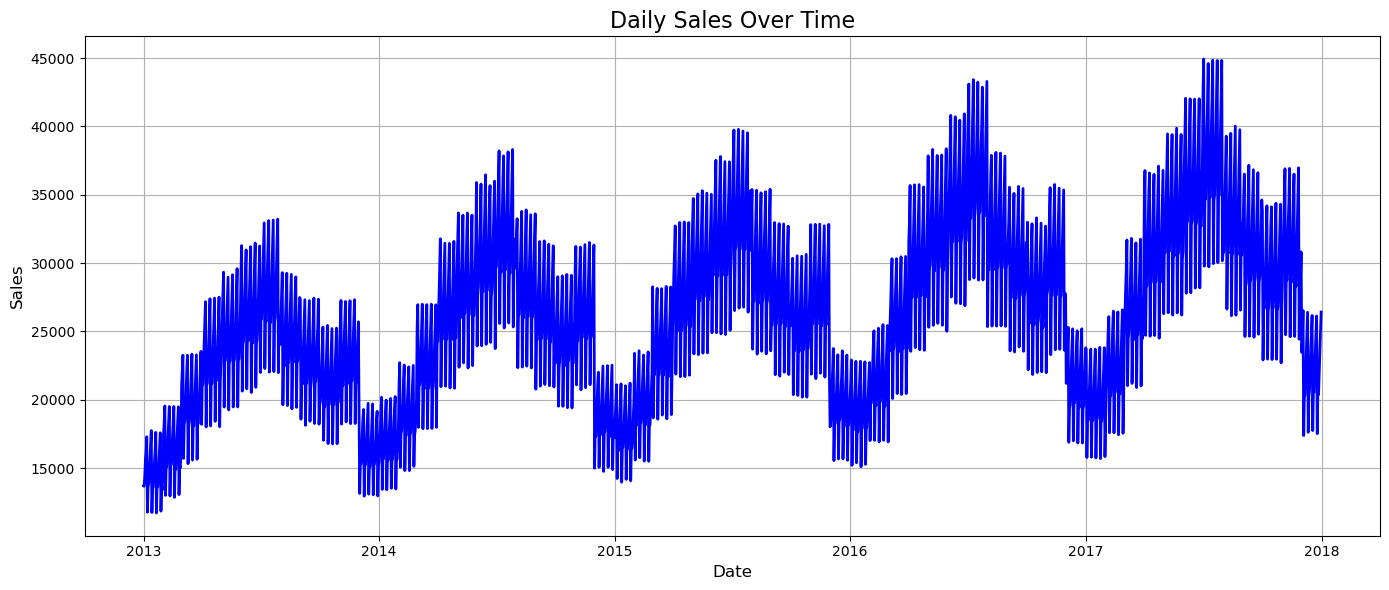

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Group data by date to get overall daily sales
daily_sales = train.groupby('date', as_index=False)['sales'].sum()

# Plot using matplotlib
plt.figure(figsize=(14, 6))
plt.plot(daily_sales['date'], daily_sales['sales'], color='blue', linewidth=2)
plt.title('Daily Sales Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


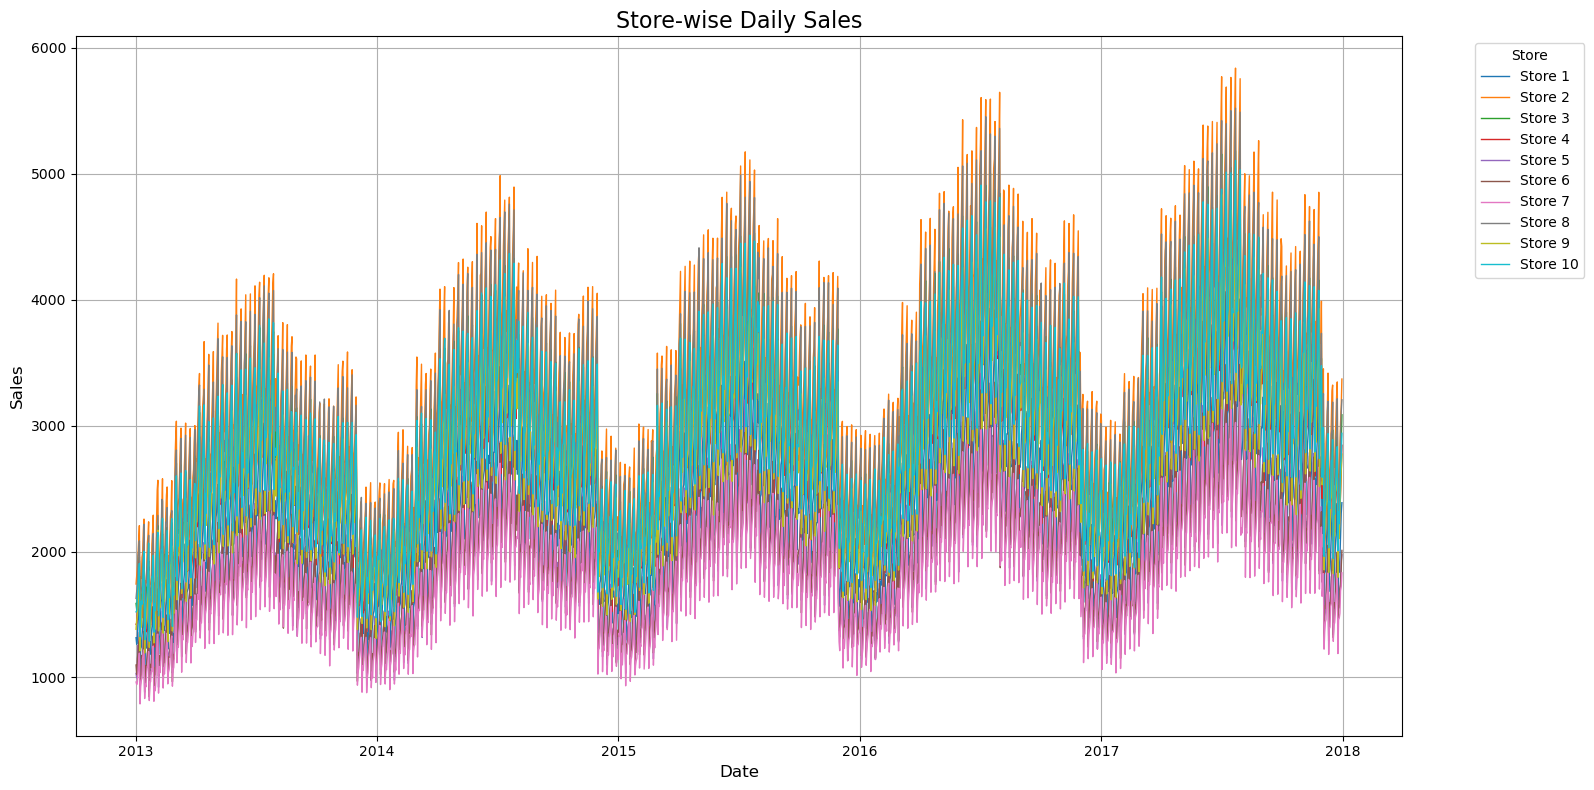

In [11]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()
daily_sales_sc = go.Scatter(x=daily_sales['date'], y=daily_sales['sales'])

# Ensure dates are datetime
store_daily_sales['date'] = pd.to_datetime(store_daily_sales['date'])

# Create a line for each store
plt.figure(figsize=(16, 8))

for store in store_daily_sales['store'].unique():
    store_data = store_daily_sales[store_daily_sales['store'] == store]
    plt.plot(store_data['date'], store_data['sales'], label=f'Store {store}', linewidth=1)

plt.title('Store-wise Daily Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(title='Store', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


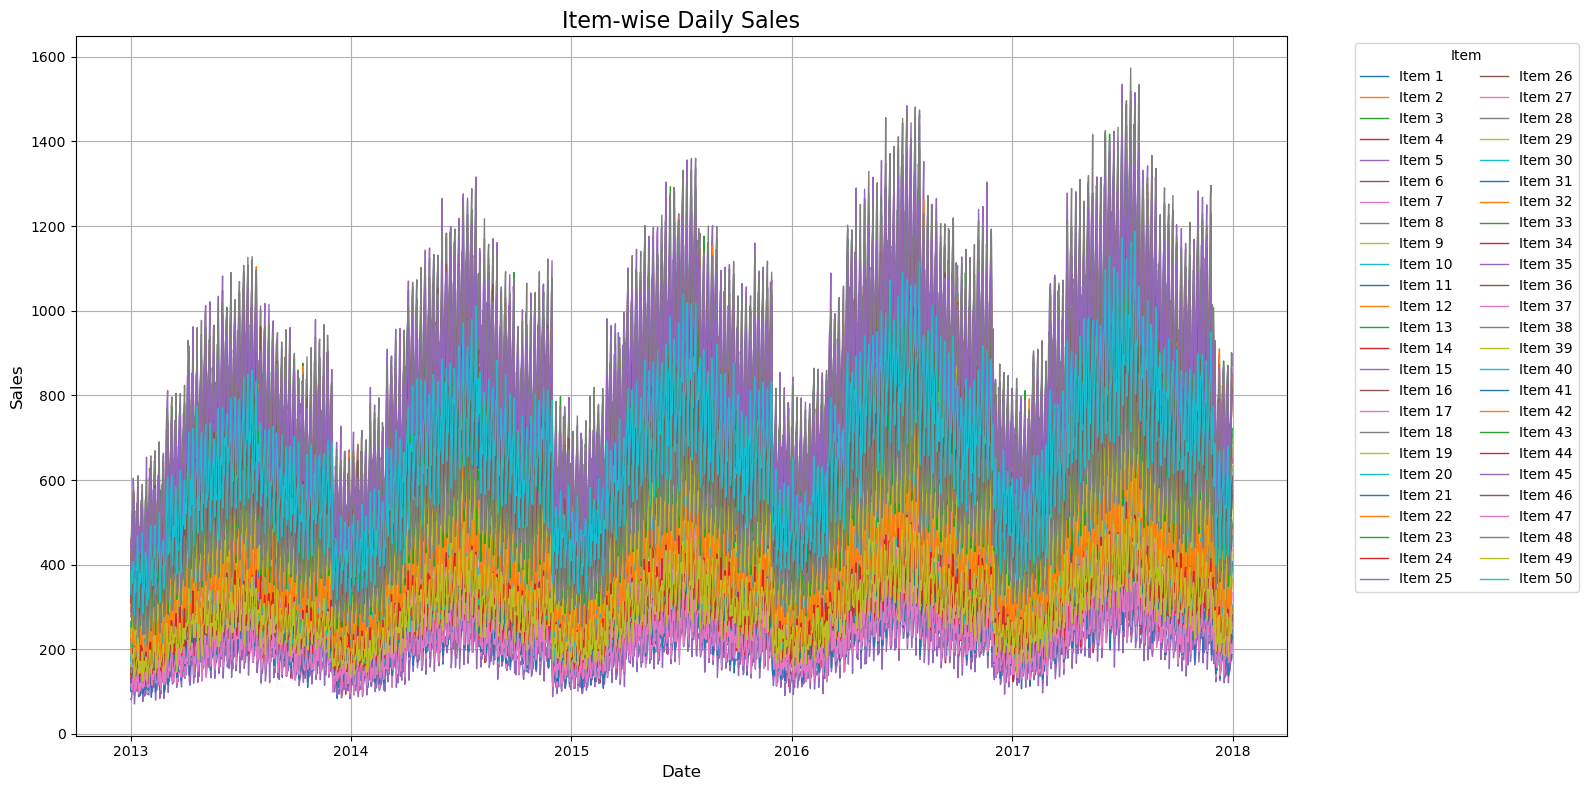

In [12]:
#Plotting store daily sales
store_daily_sales_sc = []
for store in store_daily_sales['store'].unique():
    current_store_daily_sales = store_daily_sales[(store_daily_sales['store'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['sales'], name=('Store %s' % store)))

# Ensure 'date' is in datetime format
item_daily_sales['date'] = pd.to_datetime(item_daily_sales['date'])

# Plot each item's daily sales
plt.figure(figsize=(16, 8))

for item in item_daily_sales['item'].unique():
    item_data = item_daily_sales[item_daily_sales['item'] == item]
    plt.plot(item_data['date'], item_data['sales'], label=f'Item {item}', linewidth=1)

plt.title('Item-wise Daily Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend(title='Item', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()


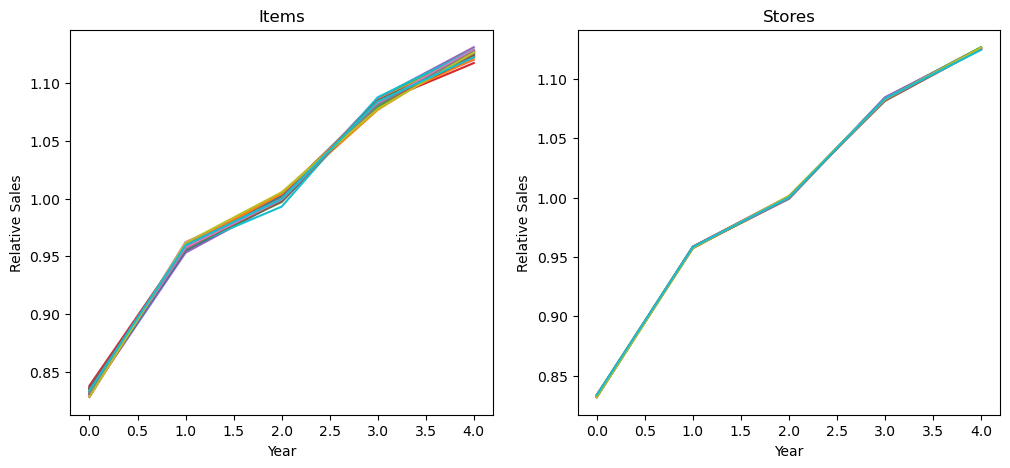

All items and stores follow a similar growth in sales over the years.


In [13]:
#Plotting daily sales by item
item_daily_sales_sc = []
for item in item_daily_sales['item'].unique():
    current_item_daily_sales = item_daily_sales[(item_daily_sales['item'] == item)]
    item_daily_sales_sc.append(go.Scatter(x=current_item_daily_sales['date'], y=current_item_daily_sales['sales'], name=('Item %s' % item)))

#plotting sales over years 
agg_year_item = pd.pivot_table(train, index='year', columns='item',
                               values='sales', aggfunc=np.mean).values
agg_year_store = pd.pivot_table(train, index='year', columns='store',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_year_item / agg_year_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.subplot(122)

plt.plot(agg_year_store / agg_year_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Year")
plt.ylabel("Relative Sales")
plt.show()
print("All items and stores follow a similar growth in sales over the years.")

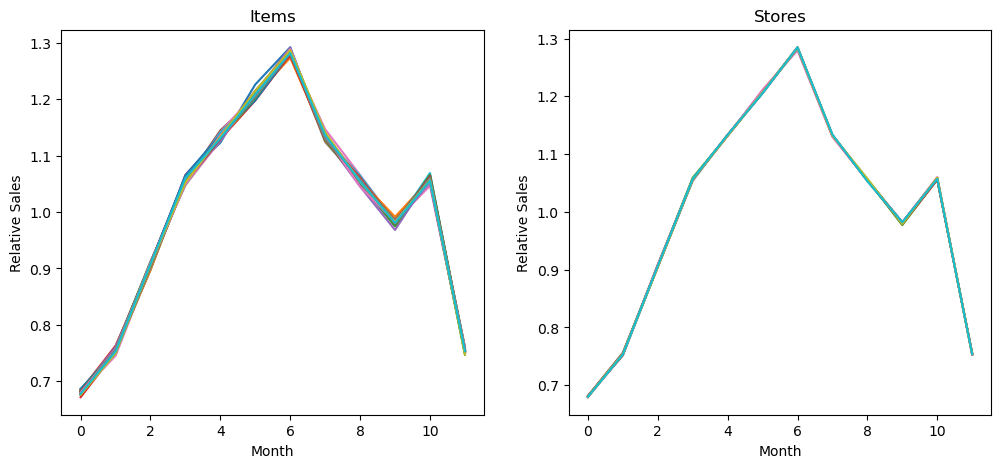

All items and stores share a common pattern in sales over the months as well.


In [14]:
#Plotting items and stores relative sales over months
agg_month_item = pd.pivot_table(train, index='month', columns='item',
                                values='sales', aggfunc=np.mean).values
agg_month_store = pd.pivot_table(train, index='month', columns='store',
                                 values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_month_item / agg_month_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_month_store / agg_month_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Month")
plt.ylabel("Relative Sales")
plt.show()
print("All items and stores share a common pattern in sales over the months as well.")

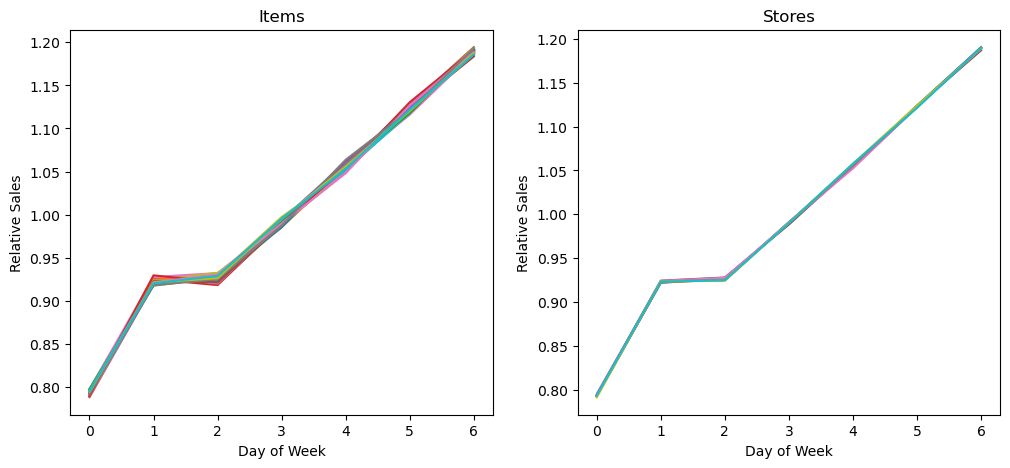

All items and stores also seem to share a common pattern in sales over the days of the week as well.


In [15]:
#Plotting relative sales of items and stores over the day of week
agg_dow_item = pd.pivot_table(train, index='dayofweek', columns='item',
                              values='sales', aggfunc=np.mean).values
agg_dow_store = pd.pivot_table(train, index='dayofweek', columns='store',
                               values='sales', aggfunc=np.mean).values

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(agg_dow_item / agg_dow_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_dow_store / agg_dow_store.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()
print("All items and stores also seem to share a common pattern in sales over the days of the week as well.")

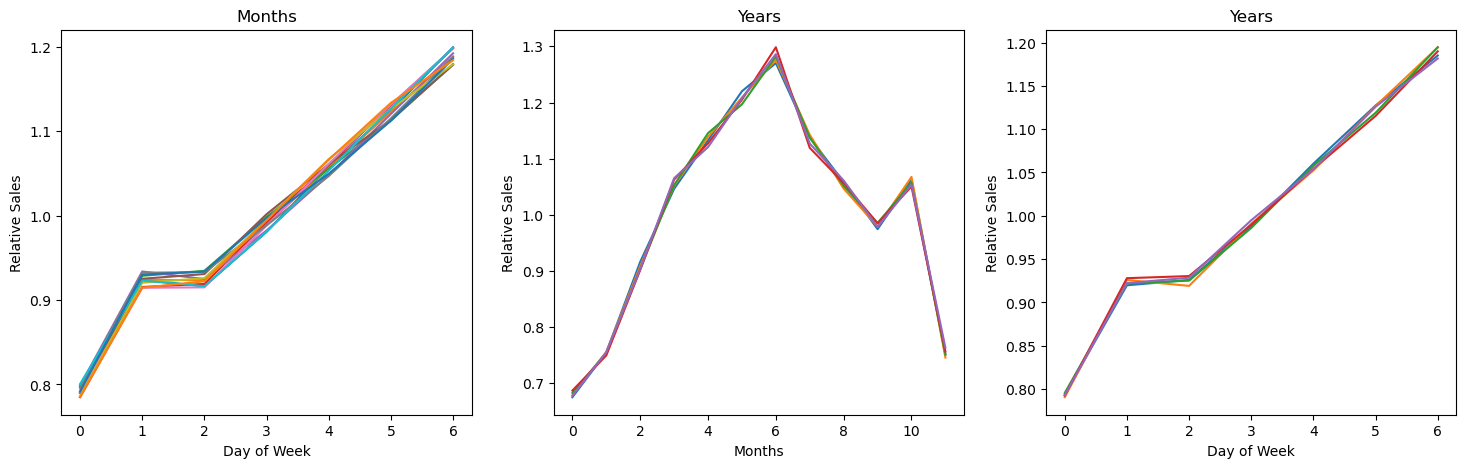

In [16]:
#checking for degeneracies in the data which can lead to missing important trends in complex datasets
agg_dow_month = pd.pivot_table(train, index='dayofweek', columns='month',
                               values='sales', aggfunc=np.mean).values
agg_month_year = pd.pivot_table(train, index='month', columns='year',
                                values='sales', aggfunc=np.mean).values
agg_dow_year = pd.pivot_table(train, index='dayofweek', columns='year',
                              values='sales', aggfunc=np.mean).values

plt.figure(figsize=(18, 5))
plt.subplot(131)
plt.plot(agg_dow_month / agg_dow_month.mean(0)[np.newaxis])
plt.title("Months")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.subplot(132)
plt.plot(agg_month_year / agg_month_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Months")
plt.ylabel("Relative Sales")
plt.subplot(133)
plt.plot(agg_dow_year / agg_dow_year.mean(0)[np.newaxis])
plt.title("Years")
plt.xlabel("Day of Week")
plt.ylabel("Relative Sales")
plt.show()


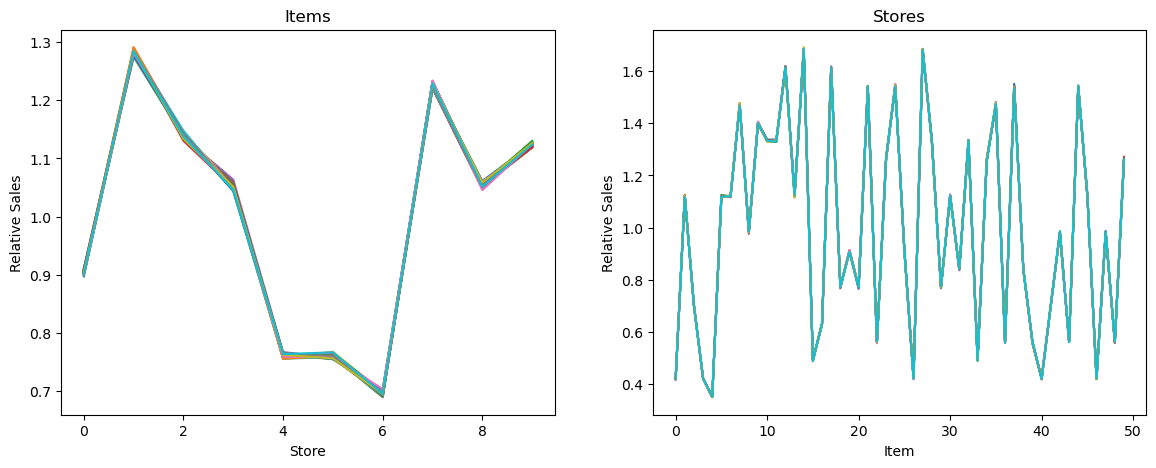

In [17]:
#checking for degeneracies in the data - items and sales which can lead to missing important trends in complex datasets
agg_store_item = pd.pivot_table(train, index='store', columns='item',
                                values='sales', aggfunc=np.mean).values

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(agg_store_item / agg_store_item.mean(0)[np.newaxis])
plt.title("Items")
plt.xlabel("Store")
plt.ylabel("Relative Sales")
plt.subplot(122)
plt.plot(agg_store_item.T / agg_store_item.T.mean(0)[np.newaxis])
plt.title("Stores")
plt.xlabel("Item")
plt.ylabel("Relative Sales")
plt.show()


<div class="alert alert-block alert-info"> <b>Train, Validation and Test Data Preparation</b> </div>

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   913000 non-null  datetime64[ns]
 1   store                  913000 non-null  int64         
 2   item                   913000 non-null  int64         
 3   sales                  913000 non-null  int64         
 4   year                   913000 non-null  int64         
 5   month                  913000 non-null  int64         
 6   day                    913000 non-null  int64         
 7   week                   913000 non-null  int32         
 8   dayofweek              913000 non-null  int64         
 9   weekday                913000 non-null  int64         
 10  dayofyear              913000 non-null  int64         
 11  quarter                913000 non-null  int64         
 12  daily_avg              913000 non-null  int6

In [19]:
# Check if 'date' is in columns
if 'date' not in train.columns:
    raise ValueError("Column 'date' not found in train DataFrame")

# Split dataset
test = train[train['date'] > '2017-08-01']
train = train[train['date'] <= '2017-07-31']

# Drop 'date' column from training data
train = train.drop('date', axis=1)


In [20]:
#creating test dataset from training dataset for deep learning models
test_v2 = train_v2[(train_v2['date'] > '2017-08-01')]
train_v2 = train_v2[(train_v2['date'] <= '2017-07-31')]
#Dropping target column - date column as other custom created date features will be used instead to train the model
train_v2= train_v2.drop(['date'], axis = 1)

In [21]:
#making a copy of train and test dataset for machine learning models
test_copy = test.copy()
train_copy = train.copy()
#test configurations for machine learning models
x_test = test_copy.drop(['sales', 'date'], axis=1)
y_test = test_copy.pop('sales')
y_date = test_copy.pop('date')
#training configurations for machine learning models and splitting validation data set by 20%
x_train,x_val,y_train,y_val = train_test_split(train_copy.drop('sales',axis=1),train_copy.pop('sales'),random_state=42,test_size=0.2)
print('Observations: %d' % (len(train_copy)))
print('Training Observations: %d' % (len(x_train)))
print('Validation Observations: %d' % (len(x_val)))
print('Testing Observations: %d' % (len(x_test)))


Observations: 836500
Training Observations: 669200
Validation Observations: 167300
Testing Observations: 76000


In [22]:
#making a copy of train and test dataset for deep learning models
test_v2_copy = test_v2.copy()
train_v2_copy = train_v2.copy()
#test configurations for deep learning models
x_test_v2 = test_v2_copy.drop(['sales', 'date'], axis=1)
y_test_v2 = test_v2_copy.pop('sales')
y_date_v2 = test_v2_copy.pop('date')
#training configurations for deep learning models and splitting validation data set by 20%
x_train_v2,x_val_v2,y_train_v2,y_val_v2 = train_test_split(train_v2_copy.drop('sales',axis=1),train_v2_copy.pop('sales'),random_state=42,test_size=0.2)
print('Observations: %d' % (len(train_v2_copy)))
print('Training Observations: %d' % (len(x_train_v2)))
print('Validation Observations: %d' % (len(x_val_v2)))
print('Testing Observations: %d' % (len(x_test_v2)))
x_test_v2.info()

Observations: 836500
Training Observations: 669200
Validation Observations: 167300
Testing Observations: 76000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 76000 entries, 1674 to 912999
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   store                  76000 non-null  int64  
 1   item                   76000 non-null  int64  
 2   year                   76000 non-null  int64  
 3   month                  76000 non-null  int64  
 4   day                    76000 non-null  int64  
 5   week                   76000 non-null  int32  
 6   dayofweek              76000 non-null  int64  
 7   weekday                76000 non-null  int64  
 8   dayofyear              76000 non-null  int64  
 9   quarter                76000 non-null  int64  
 10  daily_avg              76000 non-null  float64
 11  monthly_avg            76000 non-null  float64
 12  mean_store_item_month  76000 non-null  floa

In [23]:
#reshaping data into [samples,features,timesteps]
#data to be used for CNN, LSTM, CNN+LSTM and GRU Models
x_train_series_v2 = x_train_v2.values.reshape((x_train_v2.shape[0], x_train_v2.shape[1], 1))
x_val_series_v2 = x_val_v2.values.reshape((x_val_v2.shape[0], x_val_v2.shape[1], 1))
print('Train set shape', x_train_series_v2.shape)
print('Validation set shape', x_val_series_v2.shape)

Train set shape (669200, 42, 1)
Validation set shape (167300, 42, 1)


<div class="alert alert-block alert-info"> <b><h1>Machine Learning Models</h1></b> </div>


<div class="alert alert-block alert-info"> <b><h3> Linear Regression model</h3></b> </div>


In [25]:
#Linear Regression Model
model_lr = LinearRegression()
model_lr.fit(x_train, y_train)
#prediction on validation data
model_lr_preds_validation = model_lr.predict(x_val)
#prediction on test data
model_lr_preds_test = model_lr.predict(x_test)

In [26]:
#calculating various error metrics on validation data
print('Linear regressor validation rmse:', np.sqrt(mean_squared_error(y_val, model_lr_preds_validation)))
print ('Linear regressor validation R2 score', r2_score(y_val, model_lr_preds_validation))
print ('Linear regressor validation MAE score', mean_absolute_error(y_val, model_lr_preds_validation))
print ('Linear regressor validation MAPE score', mean_absolute_percentage_error(y_val, model_lr_preds_validation))
print ('Linear regressor validation MSE score', mean_squared_error(y_val, model_lr_preds_validation))

Linear regressor validation rmse: 8.402302703897218
Linear regressor validation R2 score 0.9137503140962526
Linear regressor validation MAE score 6.482387381009368
Linear regressor validation MAPE score 109449852575.19012
Linear regressor validation MSE score 70.59869072791851


In [27]:
#calculating various error metrics on prediction test data
print('Linear regressor test rmse:', np.sqrt(mean_squared_error(y_test, model_lr_preds_test)))
print ('Linear regressor test R2 score', r2_score(y_test, model_lr_preds_test))
print ('Linear regressor test MAE score', mean_absolute_error(y_test, model_lr_preds_test))
print ('Linear regressor test MAPE score', mean_absolute_percentage_error(y_test, model_lr_preds_test))
print ('Linear regressor test MSE score', mean_squared_error(y_test, model_lr_preds_test))

Linear regressor test rmse: 9.325051081601346
Linear regressor test R2 score 0.905195351090365
Linear regressor test MAE score 7.372624658604633
Linear regressor test MAPE score 0.17406749106895647
Linear regressor test MSE score 86.95657767447443


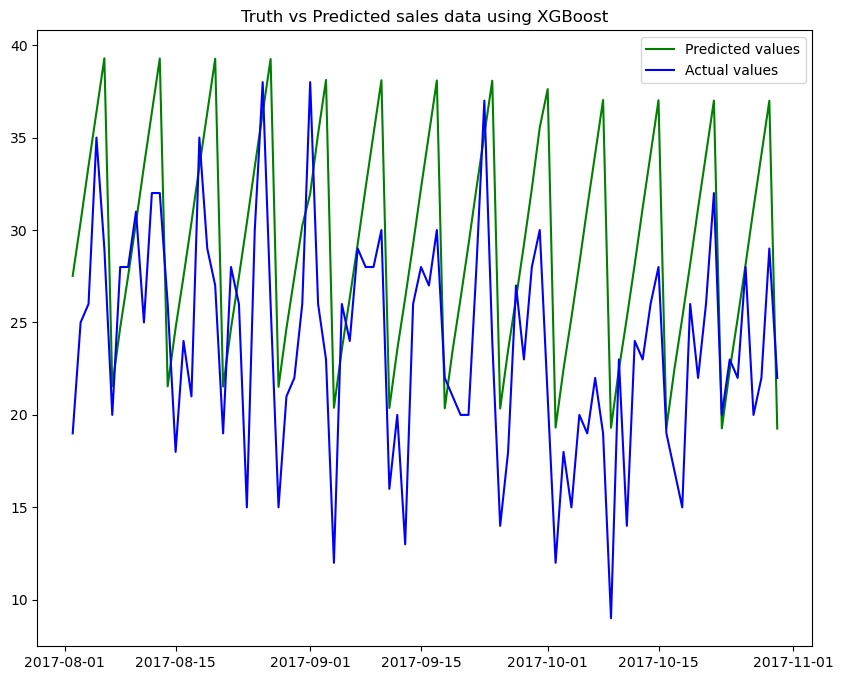

In [28]:
y_pred_linear_df = pd.DataFrame(model_lr_preds_test)
plt.figure(figsize=(10, 8))

plt.plot(y_date[:90], model_lr_preds_test[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using XGBoost')
plt.legend()

plt.show()


<div class="alert alert-block alert-info"> <b><h3> XGBoost </h3></b> </div>


In [ ]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 61.2 MB/s  0:00:03m0:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import xgboost as xgb

# XGBoost Model
def XGBmodel(x_train, x_test, y_train, y_test):
    matrix_train = xgb.DMatrix(x_train, label=y_train)
    matrix_test = xgb.DMatrix(x_test, label=y_test)
    model = xgb.train(
        params={'objective': 'reg:squarederror', 'eval_metric': 'mae'},
        dtrain=matrix_train,
        num_boost_round=500,
        early_stopping_rounds=20,
        evals=[(matrix_test, 'test')]
    )
    return model

model_xgb = XGBmodel(x_train_v2, x_val_v2, y_train_v2, y_val_v2)


[0]	test-mae:16.81372
[1]	test-mae:12.69162
[2]	test-mae:9.99100
[3]	test-mae:8.29578
[4]	test-mae:7.23866
[5]	test-mae:6.62457
[6]	test-mae:6.28586
[7]	test-mae:6.09252
[8]	test-mae:5.98311
[9]	test-mae:5.91552
[10]	test-mae:5.87280
[11]	test-mae:5.84292
[12]	test-mae:5.82204
[13]	test-mae:5.80415
[14]	test-mae:5.78888
[15]	test-mae:5.77462
[16]	test-mae:5.76700
[17]	test-mae:5.75495
[18]	test-mae:5.74605
[19]	test-mae:5.73895
[20]	test-mae:5.73415
[21]	test-mae:5.72789
[22]	test-mae:5.72118
[23]	test-mae:5.71417
[24]	test-mae:5.70835
[25]	test-mae:5.70397
[26]	test-mae:5.69759
[27]	test-mae:5.69441
[28]	test-mae:5.69172
[29]	test-mae:5.68948
[30]	test-mae:5.68589
[31]	test-mae:5.68300
[32]	test-mae:5.67960
[33]	test-mae:5.67650
[34]	test-mae:5.67329
[35]	test-mae:5.67100
[36]	test-mae:5.66906
[37]	test-mae:5.66724
[38]	test-mae:5.66615
[39]	test-mae:5.66442
[40]	test-mae:5.66293
[41]	test-mae:5.66084
[42]	test-mae:5.65943
[43]	test-mae:5.65787
[44]	test-mae:5.65714
[45]	test-mae:5.65

In [ ]:
model_xgb.save_model("MODEL_XGB.json")

In [ ]:
dval = xgb.DMatrix(x_val_v2)
dtest = xgb.DMatrix(x_test_v2)

model_xgb_valid_pred = model_xgb.predict(dval)
model_xgb_preds_test = model_xgb.predict(dtest)


In [ ]:
#Calculating various error metrics
print('XGBoost validation mse:', mean_squared_error(y_val_v2, model_xgb_valid_pred))
print('XGBoost validation rmse:', np.sqrt(mean_squared_error(y_val_v2, model_xgb_valid_pred)))
print ('XGBoost validation R2 score', r2_score(y_val_v2, model_xgb_valid_pred))
print ('XGBoost validation MAE score', mean_absolute_error(y_val_v2, model_xgb_valid_pred))
print ('XGBoost validation MAPE score', mean_absolute_percentage_error(y_val_v2, model_xgb_valid_pred))

XGBoost validation mse: 53.901159814131894
XGBoost validation rmse: 7.341740925293666
XGBoost validation R2 score 0.9341495138807423
XGBoost validation MAE score 5.634787736472012
XGBoost validation MAPE score 247946228512.53098


In [ ]:
print('XGBoost test mse:', mean_squared_error(y_test_v2, model_xgb_preds_test))
print('XGBoost test rmse:', np.sqrt(mean_squared_error(y_test_v2, model_xgb_preds_test)))
print ('XGBoost test R2 score', r2_score(y_test_v2, model_xgb_preds_test))
print ('XGBoost test MAE score', mean_absolute_error(y_test_v2, model_xgb_preds_test))
print ('XGBoost test MAPE score', mean_absolute_percentage_error(y_test_v2, model_xgb_preds_test))

XGBoost test mse: 62.673419385957786
XGBoost test rmse: 7.916654557700354
XGBoost test R2 score 0.9316701314638306
XGBoost test MAE score 6.088098846222225
XGBoost test MAPE score 0.12465065208244505


In [ ]:
y_pred_xgb = model_xgb.predict(xgb.DMatrix(x_test_v2))

In [ ]:
#plotting Truth vs Predicted sales data - XGBoost
y_pred_xgb_df = pd.DataFrame(y_pred_xgb)
plt.figure(figsize=(10, 8))

plt.plot(y_date[:90], y_pred_xgb[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test_v2[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using XGBoost')
plt.legend()

plt.show()

## Optuna XGBoost

In [ ]:
!pip install optuna
import optuna
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Define the objective function for Optuna
def objective(trial):
    # Suggest values for the hyperparameters that affect model performance
    params = {
        'objective': 'reg:squarederror',    # regression with squared error (for regression tasks)
        'eval_metric': 'mae',               # evaluation metric to minimize on validation
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),        # fraction of data to use for each tree
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # fraction of features to use for each tree
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),               # minimum loss reduction required for a split
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),       # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0)      # L2 regularization
    }
    # Create DMatrices for XGBoost training
    dtrain = xgb.DMatrix(x_train_v2, label=y_train_v2)
    dvalid = xgb.DMatrix(x_val_v2, label=y_val_v2)
    # Train the model with given hyperparameters, using early stopping on the validation set
    model = xgb.train(params, dtrain,
                      num_boost_round=500,
                      evals=[(dvalid, 'validation')],
                      early_stopping_rounds=20,
                      verbose_eval=False)
    # Predict on the validation set
    val_pred = model.predict(dvalid)
    # Calculate validation MAE for this trial
    val_mae = mean_absolute_error(y_val_v2, val_pred)
    return val_mae

# Set up Optuna study to minimize the objective (validation MAE)
sampler = optuna.samplers.TPESampler(seed=42)  # seed for reproducibility
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=50)  # try 50 different combinations of hyperparameters

# Get the best hyperparameters found by Optuna
best_params = study.best_params
# Add the fixed parameters that are not tuned (objective and eval_metric) to best_params
best_params['objective'] = 'reg:squarederror'
best_params['eval_metric'] = 'mae'

# Train a final XGBoost model using the best hyperparameters on the training data
dtrain = xgb.DMatrix(x_train_v2, label=y_train_v2)
dval = xgb.DMatrix(x_val_v2, label=y_val_v2)
dtest = xgb.DMatrix(x_test_v2, label=y_test_v2)
model_xgb_tuned = xgb.train(best_params, dtrain,
                            num_boost_round=500,
                            evals=[(dval, 'validation')],
                            early_stopping_rounds=20,
                            verbose_eval=False)
# Save the tuned model (optional)
model_xgb_tuned.save_model("MODEL_XGB_TUNED.json")

# Make predictions with the tuned model
val_preds = model_xgb_tuned.predict(dval)
test_preds = model_xgb_tuned.predict(dtest)

# Calculate and print evaluation metrics for validation set
print('XGBoost (Tuned) validation MSE:', mean_squared_error(y_val_v2, val_preds))
print('XGBoost (Tuned) validation RMSE:', np.sqrt(mean_squared_error(y_val_v2, val_preds)))
print('XGBoost (Tuned) validation R2:', r2_score(y_val_v2, val_preds))
print('XGBoost (Tuned) validation MAE:', mean_absolute_error(y_val_v2, val_preds))
print('XGBoost (Tuned) validation MAPE:', mean_absolute_percentage_error(y_val_v2, val_preds))

# Calculate and print evaluation metrics for test set
print('XGBoost (Tuned) test MSE:', mean_squared_error(y_test_v2, test_preds))
print('XGBoost (Tuned) test RMSE:', np.sqrt(mean_squared_error(y_test_v2, test_preds)))
print('XGBoost (Tuned) test R2:', r2_score(y_test_v2, test_preds))
print('XGBoost (Tuned) test MAE:', mean_absolute_error(y_test_v2, test_preds))
print('XGBoost (Tuned) test MAPE:', mean_absolute_percentage_error(y_test_v2, test_preds))


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [optuna]2m3/4 [optuna]]


[I 2025-08-14 03:46:45,345] A new study created in memory with name: no-name-f5a9bee7-fa34-42b6-b7b0-7bf0142c1485
[I 2025-08-14 03:46:51,915] Trial 0 finished with value: 5.611875566692318 and parameters: {'max_depth': 5, 'learning_rate': 0.2536999076681772, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'min_child_weight': 2, 'gamma': 0.7799726016810132, 'reg_alpha': 0.2904180608409973, 'reg_lambda': 4.330880728874676}. Best is trial 0 with value: 5.611875566692318.
[I 2025-08-14 03:46:57,927] Trial 1 finished with value: 5.600321667725927 and parameters: {'max_depth': 7, 'learning_rate': 0.11114989443094977, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'min_child_weight': 9, 'gamma': 1.0616955533913808, 'reg_alpha': 0.9091248360355031, 'reg_lambda': 0.9170225492671691}. Best is trial 1 with value: 5.600321667725927.
[I 2025-08-14 03:47:09,086] Trial 2 finished with value: 5.586835907464675 and parameters: {'max_depth': 5, 'learnin

XGBoost (Tuned) validation MSE: 52.595638772430185
XGBoost (Tuned) validation RMSE: 7.252285072474067
XGBoost (Tuned) validation R2: 0.9357444553538279
XGBoost (Tuned) validation MAE: 5.572385884006795
XGBoost (Tuned) validation MAPE: 261936115351.84152
XGBoost (Tuned) test MSE: 60.26075904395782
XGBoost (Tuned) test RMSE: 7.762780368138585
XGBoost (Tuned) test R2: 0.93430054106341
XGBoost (Tuned) test MAE: 5.976463679966174
XGBoost (Tuned) test MAPE: 0.12231011036163579



<div class="alert alert-block alert-info"> <b><h3>  Bayesian XGBoost </h3></b> </div>


XGB-Ens validation MSE: 52.59790001281694
XGB-Ens test MSE: 60.16683158416611
XGB-Ens test RMSE: 7.75672814943041
XGB-Ens test R2: 0.9344029457357956
XGB-Ens test MAE: 5.979823078544516
XGB-Ens test MAPE: 0.12309065871854914


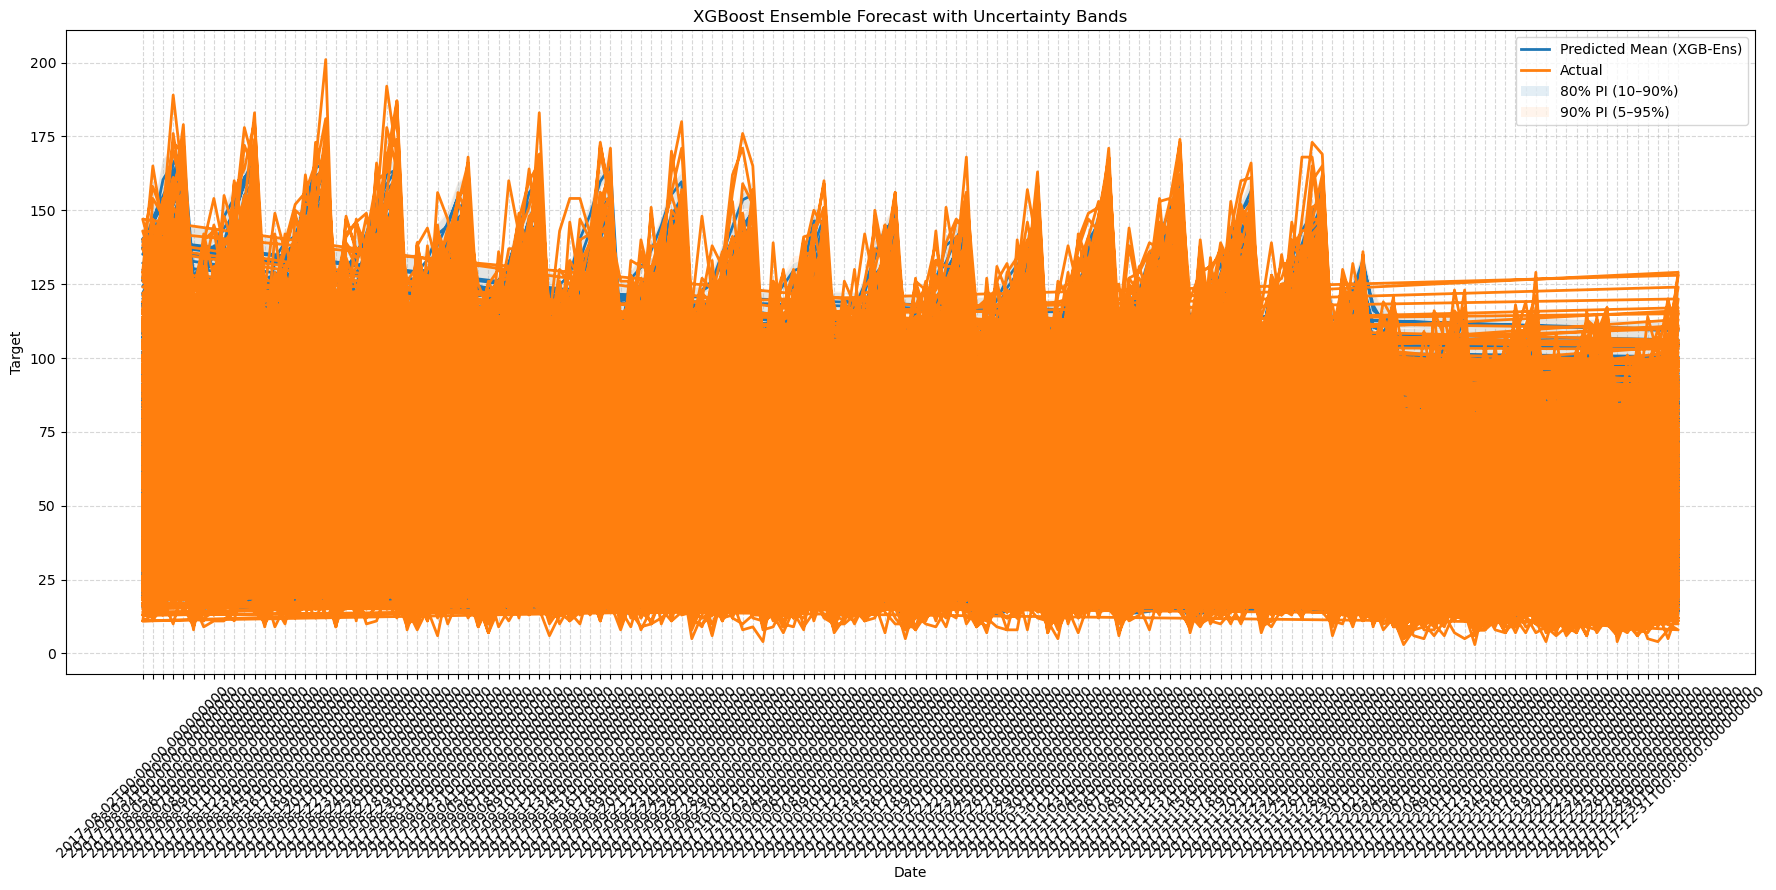

In [29]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

def to_numpy(a):
    return a.to_numpy() if hasattr(a, "to_numpy") else np.asarray(a)

def train_xgb_base(x_train, y_train, x_valid, y_valid, seed=42, params=None, num_boost_round=500, early_stopping_rounds=20):
    x_train = to_numpy(x_train); y_train = to_numpy(y_train).ravel()
    x_valid = to_numpy(x_valid); y_valid = to_numpy(y_valid).ravel()

    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)

    default_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'eta': 0.05,
        'max_depth': 6,
        'min_child_weight': 1.0,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda': 1.0,
        'alpha': 0.0,
        'seed': seed,
    }
    if params:
        default_params.update(params)

    model = xgb.train(
        params=default_params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dvalid, 'valid')],
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=False
    )
    return model

def xgb_bayesian_ensemble(x_train, y_train, x_valid, y_valid, x_test,
                          n_models=30, bootstrap=True, seed=42,
                          base_params=None):
    rng = np.random.default_rng(seed)
    x_train_np = to_numpy(x_train); y_train_np = to_numpy(y_train).ravel()
    x_valid_np = to_numpy(x_valid); y_valid_np = to_numpy(y_valid).ravel()
    x_test_np  = to_numpy(x_test)

    preds_valid = []
    preds_test  = []

    n = x_train_np.shape[0]
    for m in range(n_models):
        # Bootstrap indices (or use full data with different seeds)
        if bootstrap:
            idx = rng.integers(0, n, size=n)
            Xb, yb = x_train_np[idx], y_train_np[idx]
        else:
            Xb, yb = x_train_np, y_train_np

        model = train_xgb_base(
            Xb, yb, x_valid_np, y_valid_np,
            seed=seed + m,
            params=base_params
        )

        dvalid = xgb.DMatrix(x_valid_np)
        dtest  = xgb.DMatrix(x_test_np)
        preds_valid.append(model.predict(dvalid))
        preds_test.append(model.predict(dtest))

    preds_valid = np.stack(preds_valid, axis=0)  # (M, N_valid)
    preds_test  = np.stack(preds_test, axis=0)   # (M, N_test)

    out = {
        'valid_mean': preds_valid.mean(axis=0),
        'valid_std':  preds_valid.std(axis=0),
        'test_mean':  preds_test.mean(axis=0),
        'test_std':   preds_test.std(axis=0),
        'valid_preds_all': preds_valid,
        'test_preds_all':  preds_test,
    }
    return out

# ---- Run the ensemble ----
params = {
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
}
ens = xgb_bayesian_ensemble(
    x_train_v2, y_train_v2,
    x_val_v2,   y_val_v2,
    x_test_v2,
    n_models=30,            # increase to 50/100 for smoother uncertainty
    bootstrap=True,
    seed=42,
    base_params=params
)

# ---- Metrics using mean predictions ----
val_mean = ens['valid_mean']; test_mean = ens['test_mean']
print("XGB-Ens validation MSE:", mean_squared_error(y_val_v2, val_mean))
print("XGB-Ens test MSE:", mean_squared_error(y_test_v2, test_mean))
print("XGB-Ens test RMSE:", np.sqrt(mean_squared_error(y_test_v2, test_mean)))
print("XGB-Ens test R2:", r2_score(y_test_v2, test_mean))
print("XGB-Ens test MAE:", mean_absolute_error(y_test_v2, test_mean))
print("XGB-Ens test MAPE:", mean_absolute_percentage_error(y_test_v2, test_mean))

# ---- Uncertainty bands (empirical) ----
test_all = ens['test_preds_all']  # (M, N_test)
p05 = np.percentile(test_all, 5, axis=0)
p95 = np.percentile(test_all, 95, axis=0)
p10 = np.percentile(test_all, 10, axis=0)
p90 = np.percentile(test_all, 90, axis=0)

# (Alternatively, normal approx with std)
# z90, z95 = 1.645, 1.960
# upper_90 = test_mean + z90*ens['test_std']
# upper_95 = test_mean + z95*ens['test_std']

# ---- Plot (clean, light bands) ----
plt.figure(figsize=(18, 9))
x_plot = np.array(y_date).astype(str)

plt.plot(x_plot, test_mean, label='Predicted Mean (XGB-Ens)', linewidth=2)
plt.plot(x_plot, y_test_v2, label='Actual', linewidth=2)

# 90% and 95% empirical intervals
plt.fill_between(x_plot, p10, p90, alpha=0.12, label='80% PI (10–90%)')
plt.fill_between(x_plot, p05, p95, alpha=0.08, label='90% PI (5–95%)')

plt.title("XGBoost Ensemble Forecast with Uncertainty Bands")
plt.xlabel("Date"); plt.ylabel("Target")
plt.xticks(rotation=45); plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(); plt.tight_layout(); plt.show()


## Bayesian Optuna XGBoost

[I 2025-08-14 05:15:59,883] A new study created in memory with name: no-name-e7b40332-1733-4281-8ba7-9c7b1544acb6
[I 2025-08-14 05:16:19,269] Trial 0 finished with value: 5.60706307117339 and parameters: {'eta': 0.03574712922600244, 'max_depth': 12, 'min_child_weight': 7.453942447208348, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'alpha': 0.2904180608409973, 'lambda': 4.330880728874676}. Best is trial 0 with value: 5.60706307117339.
[I 2025-08-14 05:16:25,290] Trial 1 finished with value: 5.597621844312209 and parameters: {'eta': 0.07725378389307355, 'max_depth': 10, 'min_child_weight': 0.6955526958101232, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.9162213204002109, 'gamma': 1.0616955533913808, 'alpha': 0.9091248360355031, 'lambda': 0.9170225492671691}. Best is trial 1 with value: 5.597621844312209.
[I 2025-08-14 05:16:40,233] Trial 2 finished with value: 5.577551542918838 and parameters: {'eta': 0.02814509271606065


=== Optuna: Best Validation MAE ===
5.574387205372438

=== Optuna: Best Params ===
eta: 0.02896159882269652
max_depth: 9
min_child_weight: 9.115478123138896
subsample: 0.5724586136521898
colsample_bytree: 0.8848444647744271
gamma: 2.2663676821427727
alpha: 0.3787531928341581
lambda: 4.303037842964204

=== Final base_params used for Ensemble ===
objective: reg:squarederror
eval_metric: mae
eta: 0.02896159882269652
max_depth: 9
min_child_weight: 9.115478123138896
subsample: 0.5724586136521898
colsample_bytree: 0.8848444647744271
lambda: 4.303037842964204
alpha: 0.3787531928341581
gamma: 2.2663676821427727

=== Validation Metrics (Ensemble Mean) ===
MSE : 52.51345182214934
RMSE: 7.246616577558753
R2  : 0.9358448622958551
MAE : 5.568595728788701
MAPE: 258796784354.88162

=== Test Metrics (Ensemble Mean) ===
MSE : 59.97315670037164
RMSE: 7.744233771030652
R2  : 0.9346141003126176
MAE : 5.967755628686202
MAPE: 0.12255141117230434


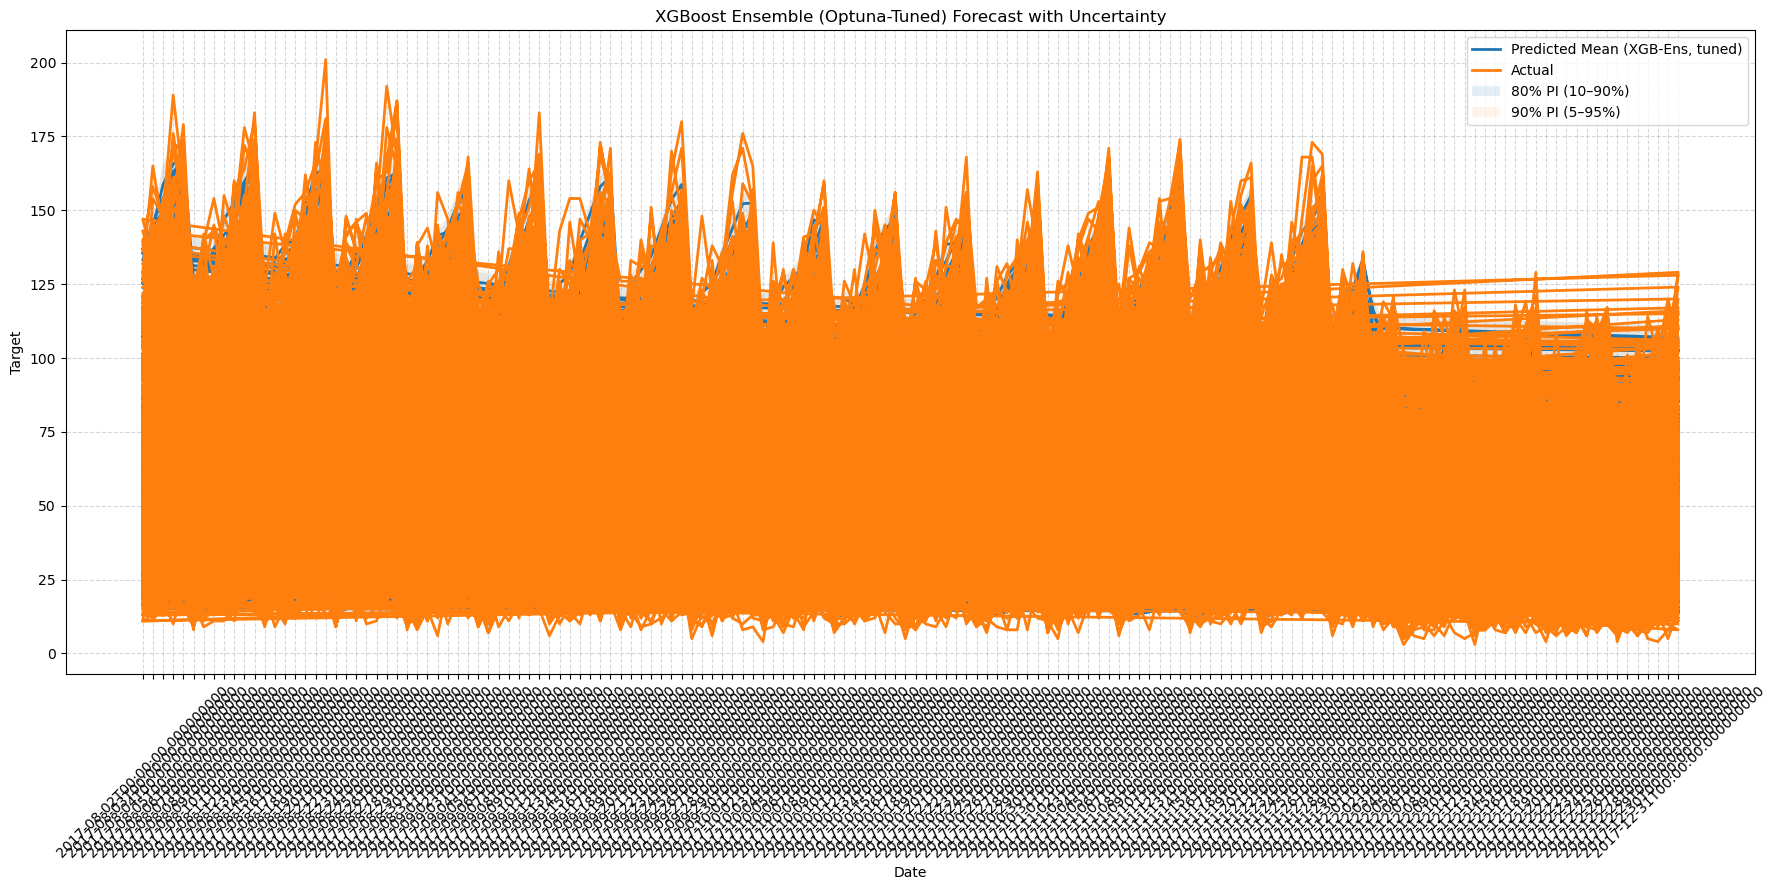

In [28]:
# ====== INSTALL (uncomment in notebook if needed) ======
# !pip install optuna xgboost

import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error
)
# Safe MAPE (sklearn's may not exist in older versions)
try:
    from sklearn.metrics import mean_absolute_percentage_error
except Exception:
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        eps = np.finfo(float).eps
        return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps)))

import matplotlib.pyplot as plt

# -----------------------
# Utilities (unchanged)
# -----------------------
def to_numpy(a):
    return a.to_numpy() if hasattr(a, "to_numpy") else np.asarray(a)

def train_xgb_base(x_train, y_train, x_valid, y_valid,
                   seed=42, params=None, num_boost_round=500, early_stopping_rounds=20):
    x_train = to_numpy(x_train); y_train = to_numpy(y_train).ravel()
    x_valid = to_numpy(x_valid); y_valid = to_numpy(y_valid).ravel()

    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)

    default_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'eta': 0.05,
        'max_depth': 6,
        'min_child_weight': 1.0,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda': 1.0,
        'alpha': 0.0,
        'seed': seed,
    }
    if params:
        default_params.update(params)

    model = xgb.train(
        params=default_params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dvalid, 'valid')],
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=False
    )
    return model

def xgb_bayesian_ensemble(x_train, y_train, x_valid, y_valid, x_test,
                          n_models=30, bootstrap=True, seed=42,
                          base_params=None):
    rng = np.random.default_rng(seed)
    x_train_np = to_numpy(x_train); y_train_np = to_numpy(y_train).ravel()
    x_valid_np = to_numpy(x_valid); y_valid_np = to_numpy(y_valid).ravel()
    x_test_np  = to_numpy(x_test)

    preds_valid = []
    preds_test  = []

    n = x_train_np.shape[0]
    for m in range(n_models):
        # Bootstrap indices (or use full data with different seeds)
        if bootstrap:
            idx = rng.integers(0, n, size=n)
            Xb, yb = x_train_np[idx], y_train_np[idx]
        else:
            Xb, yb = x_train_np, y_train_np

        model = train_xgb_base(
            Xb, yb, x_valid_np, y_valid_np,
            seed=seed + m,
            params=base_params
        )

        dvalid = xgb.DMatrix(x_valid_np)
        dtest  = xgb.DMatrix(x_test_np)
        preds_valid.append(model.predict(dvalid))
        preds_test.append(model.predict(dtest))

    preds_valid = np.stack(preds_valid, axis=0)  # (M, N_valid)
    preds_test  = np.stack(preds_test, axis=0)   # (M, N_test)

    out = {
        'valid_mean': preds_valid.mean(axis=0),
        'valid_std':  preds_valid.std(axis=0),
        'test_mean':  preds_test.mean(axis=0),
        'test_std':   preds_test.std(axis=0),
        'valid_preds_all': preds_valid,
        'test_preds_all':  preds_test,
    }
    return out

# --------------------------------------------
# Optuna: tune base_params (no logic changes)
# --------------------------------------------
def objective(trial):
    # Suggest impactful hyperparams
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),            # learning_rate
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.5, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'alpha': trial.suggest_float('alpha', 0.0, 5.0),   # L1
        'lambda': trial.suggest_float('lambda', 0.0, 5.0)  # L2
    }

    # Train 1 model (same training routine / early stopping)
    model = train_xgb_base(
        x_train_v2, y_train_v2,
        x_val_v2,   y_val_v2,
        seed=42,
        params=params,
        num_boost_round=500,
        early_stopping_rounds=20
    )

    # Validation MAE is the optimization target
    dval = xgb.DMatrix(to_numpy(x_val_v2))
    val_pred = model.predict(dval)
    val_mae = mean_absolute_error(y_val_v2, val_pred)
    return val_mae

# Create study (TPE sampler, reproducible seed)
study = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=40, show_progress_bar=False)

print("\n=== Optuna: Best Validation MAE ===")
print(study.best_value)
print("\n=== Optuna: Best Params ===")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

# Merge Optuna params into your base params (keep your logic)
best_base_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    # keep your defaults but override with tuned values
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1.0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1.0,
    'alpha': 0.0,
}
best_base_params.update(study.best_params)  # <- tuned values win

print("\n=== Final base_params used for Ensemble ===")
for k, v in best_base_params.items():
    print(f"{k}: {v}")

# ---------------------------
# Run your ensemble as-is
# ---------------------------
ens = xgb_bayesian_ensemble(
    x_train_v2, y_train_v2,
    x_val_v2,   y_val_v2,
    x_test_v2,
    n_models=30,            # same as your original
    bootstrap=True,
    seed=42,
    base_params=best_base_params
)

# ---- Metrics using mean predictions ----
val_mean = ens['valid_mean']; test_mean = ens['test_mean']

print("\n=== Validation Metrics (Ensemble Mean) ===")
print("MSE :", mean_squared_error(y_val_v2, val_mean))
print("RMSE:", np.sqrt(mean_squared_error(y_val_v2, val_mean)))
print("R2  :", r2_score(y_val_v2, val_mean))
print("MAE :", mean_absolute_error(y_val_v2, val_mean))
print("MAPE:", mean_absolute_percentage_error(y_val_v2, val_mean))

print("\n=== Test Metrics (Ensemble Mean) ===")
print("MSE :", mean_squared_error(y_test_v2, test_mean))
print("RMSE:", np.sqrt(mean_squared_error(y_test_v2, test_mean)))
print("R2  :", r2_score(y_test_v2, test_mean))
print("MAE :", mean_absolute_error(y_test_v2, test_mean))
print("MAPE:", mean_absolute_percentage_error(y_test_v2, test_mean))

# ---- Uncertainty bands (empirical) ----
test_all = ens['test_preds_all']  # (M, N_test)
p05 = np.percentile(test_all, 5, axis=0)
p95 = np.percentile(test_all, 95, axis=0)
p10 = np.percentile(test_all, 10, axis=0)
p90 = np.percentile(test_all, 90, axis=0)

# ---- Plot (clean, light bands) ----
plt.figure(figsize=(18, 9))
x_plot = np.array(y_date).astype(str)

plt.plot(x_plot, test_mean, label='Predicted Mean (XGB-Ens, tuned)', linewidth=2)
plt.plot(x_plot, y_test_v2, label='Actual', linewidth=2)

plt.fill_between(x_plot, p10, p90, alpha=0.12, label='80% PI (10–90%)')
plt.fill_between(x_plot, p05, p95, alpha=0.08, label='90% PI (5–95%)')

plt.title("XGBoost Ensemble (Optuna-Tuned) Forecast with Uncertainty")
plt.xlabel("Date"); plt.ylabel("Target")
plt.xticks(rotation=45); plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(); plt.tight_layout(); plt.show()


<div class="alert alert-block alert-info"> <b><h1>Deep Learning Models</h1></b> </div>

<div class="alert alert-block alert-info"> <b><h1>CNN</h1></b> </div>

### CNN for Time Series Forecasting

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape [samples, timesteps, features].

#### Data preprocess
* Reshape into [samples, timesteps, features].
* This same reshaped data will be used on the CNN, LSTM, CNN+LSTM, GRU model.

In [30]:
x_train_v2.shape

(669200, 42)

In [31]:
#reshaping data into [samples,features,timesteps]
#data to be used for CNN, LSTM, CNN+LSTM and GRU Models
x_train_series_v2 = x_train_v2.values.reshape((x_train_v2.shape[0], x_train_v2.shape[1], 1))
x_val_series_v2 = x_val_v2.values.reshape((x_val_v2.shape[0], x_val_v2.shape[1], 1))
print('Train set shape', x_train_series_v2.shape)
print('Validation set shape', x_val_series_v2.shape)

Train set shape (669200, 42, 1)
Validation set shape (167300, 42, 1)


In [32]:
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential




2025-08-14 06:45:37.880751: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755134137.902772 3857117 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755134137.909937 3857117 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755134137.927220 3857117 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755134137.927233 3857117 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755134137.927235 3857117 computation_placer.cc:177] computation placer alr

In [33]:
#Setting model parameters
epochs = 15
batch = 128
lr = 0.0003
adam = optimizers.Adam(lr)

2025-08-14 06:45:41.293017: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [34]:
#CNN Model
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_train_series_v2.shape[1], x_train_series_v2.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 41, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        64,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,293 (251.14 KB)

 Trainable params: 64,293 (251.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#fitting model on training data 
cnn_history = model_cnn.fit(x_train_series_v2, y_train_v2, validation_data=(x_val_series_v2, y_val_v2), epochs=epochs, verbose=2)



Epoch 1/15
20913/20913 - 111s - 5ms/step - loss: 70.8757 - mae: 6.4251 - mape: 15.4949 - mse: 70.8757 - val_loss: 62.2093 - val_mae: 6.0463 - val_mape: 57689.3672 - val_mse: 62.2093
Epoch 2/15
20913/20913 - 108s - 5ms/step - loss: 60.6247 - mae: 5.9748 - mape: 14.2446 - mse: 60.6247 - val_loss: 60.6080 - val_mae: 5.9267 - val_mape: 59415.8633 - val_mse: 60.6080
Epoch 3/15
20913/20913 - 109s - 5ms/step - loss: 59.1333 - mae: 5.9043 - mape: 14.0683 - mse: 59.1333 - val_loss: 57.9760 - val_mae: 5.8548 - val_mape: 60862.9375 - val_mse: 57.9760
Epoch 4/15
20913/20913 - 109s - 5ms/step - loss: 58.4032 - mae: 5.8704 - mape: 13.9933 - mse: 58.4032 - val_loss: 59.2675 - val_mae: 5.9356 - val_mape: 56809.4375 - val_mse: 59.2675
Epoch 5/15
20913/20913 - 108s - 5ms/step - loss: 57.9997 - mae: 5.8515 - mape: 13.9521 - mse: 57.9997 - val_loss: 57.3908 - val_mae: 5.8012 - val_mape: 54010.7227 - val_mse: 57.3908
Epoch 6/15
20913/20913 - 108s - 5ms/step - loss: 57.6935 - mae: 5.8382 - mape: 13.9227 - m

In [ ]:
model_cnn.save("CNN_MODEL.h5")

In [ ]:
#predicting on test data
y_pred_cnn = model_cnn.predict(x_test_v2)

In [ ]:
#CNN
print('CNN test rmse:', np.sqrt(mean_squared_error(y_test_v2, y_pred_cnn)))
print ('CNN test R2 score', r2_score(y_test_v2, y_pred_cnn))
print('CNN test MAE:', mean_absolute_error(y_test_v2, y_pred_cnn))
print ('CNN test MAPE score', mean_absolute_percentage_error(y_test_v2, y_pred_cnn))
print ('CNN test MSE score', mean_squared_error(y_test_v2, y_pred_cnn))

In [ ]:
#plotting trainig and validation loss
import matplotlib.pyplot as plt

cnn_mse = cnn_history.history['mse']
cnn_val_mse = cnn_history.history['val_mse']
cnn_loss = cnn_history.history['loss']
cnn_val_loss = cnn_history.history['val_loss']

epochs = range(1, len(cnn_mse) + 1)
#epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
# "bo" is for "blue dot"
plt.plot(epochs[:], cnn_loss[:], 'bo', color='green', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs[:], cnn_val_loss[:], 'b', color='brown', label='Validation loss')
plt.title('Training and validation loss - CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
#plotting truth v/s predicted sales data using CNN model
y_pred_cnn_df = pd.DataFrame(y_pred_cnn)
plt.figure(figsize=(14, 10))

plt.plot(y_date[:90], y_pred_cnn[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test_v2[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using CNN')
plt.legend()

plt.show()

<div class="alert alert-block alert-info"> <b><h3>LSTM</h3></b> </div>

## Original LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop

# ===== LSTM model configuration =====
model_lstm = Sequential()
model_lstm.add(
    LSTM(
        42,
        activation='sigmoid',
        input_shape=(x_train_series_v2.shape[1], x_train_series_v2.shape[2])
    )
)
model_lstm.add(Dense(1))

model_lstm.compile(
    loss='mse',
    optimizer=RMSprop(),
    metrics=['mae', 'mse', 'mape']
)

model_lstm.summary()


In [ ]:
#fitting model on training data 
lstm_history = model_lstm.fit(x_train_series_v2, y_train_v2, validation_data=(x_val_series_v2, y_val_v2), epochs=20, batch_size=128, verbose=2)


In [ ]:
model_lstm.save("LSTM_MODEL.h5")

In [ ]:
#predicting on test data
y_pred_lstm = model_lstm.predict(x_test_v2)

In [ ]:
#plotting training and validation loss using LSTM#predicting on test data
y_pred_lstm = model_lstm.predict(x_test_v2)
import matplotlib.pyplot as plt

mse = lstm_history.history['mse']
val_mse = lstm_history.history['val_mse']
loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']

epochs = range(1, len(mse) + 1)
#epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
# "bo" is for "blue dot"
plt.plot(epochs[1:], loss[1:], 'bo', color='green', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs[1:], val_loss[1:], 'b', color='brown', label='Validation loss')
plt.title('Training and validation loss - LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
#plotting graph: Truth v/s predicted sales data using LSTM
y_pred_lstm_df = pd.DataFrame(y_pred_lstm)
plt.figure(figsize=(18, 10))

plt.plot(y_date[:90], y_pred_lstm[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test_v2[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using LSTM')
plt.legend()

plt.show()

In [ ]:
#LSTM
print('LSTM test rmse:', np.sqrt(mean_squared_error(y_test_v2, y_pred_lstm)))
print ('LSTM test R2 score', r2_score(y_test_v2, y_pred_lstm))
print('LSTM test MAE:', mean_absolute_error(y_test_v2, y_pred_lstm))
print ('LSTM test MAPE score', mean_absolute_percentage_error(y_test_v2, y_pred_lstm))
print ('LSTM test MSE score', mean_squared_error(y_test_v2, y_pred_lstm))

<div class="alert alert-block alert-info"> <b><h3>Bayesian LSTM</h3></b> </div>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Device and seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# --- Define Bayesian LSTM with Dropout ---
class BayesianLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=42, dropout_rate=0.3):
        super(BayesianLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Use last time step
        out = self.dropout(out)
        out = self.fc(out)
        return out

# --- Monte Carlo prediction with active dropout ---
def predict_mc(model, x, n_iter=50):
    model.train()  # keep dropout active
    preds = [model(x).detach().cpu().numpy() for _ in range(n_iter)]
    preds = np.stack(preds)
    return preds.mean(axis=0), preds.std(axis=0)

# --- Convert to Torch Tensor safely ---
def to_tensor(data, expect_3d=False):
    if isinstance(data, (pd.Series, pd.DataFrame)):
        data = data.to_numpy()
    tensor = torch.tensor(data, dtype=torch.float32)
    if expect_3d and tensor.ndim == 2:
        tensor = tensor.unsqueeze(-1)  # Add feature dimension
    return tensor.to(device)

# === Replace the following with your actual dataset variables ===
# x_train_series_v2, y_train_v2, x_val_series_v2, y_val_v2, x_test_v2, y_test_v2, y_date

# --- Prepare Data ---
X_train = to_tensor(x_train_series_v2, expect_3d=True)
y_train = to_tensor(y_train_v2).view(-1, 1)

X_val = to_tensor(x_val_series_v2, expect_3d=True)
y_val = to_tensor(y_val_v2).view(-1, 1)

X_test = to_tensor(x_test_v2, expect_3d=True)
y_test = to_tensor(y_test_v2).view(-1, 1)

# --- Model Setup ---
input_size = X_train.shape[2]
model = BayesianLSTM(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

# --- Training Loop ---
epochs = 20
batch_size = 128
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))
    total_loss = 0

    for i in range(0, X_train.size(0), batch_size):
        idx = permutation[i:i + batch_size]
        xb, yb = X_train[idx], y_train[idx]

        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val).item()

    avg_train_loss = total_loss / (X_train.size(0) // batch_size)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

# --- Monte Carlo Dropout Prediction ---
y_pred_mean, y_pred_std = predict_mc(model, X_test, n_iter=50)
y_true_np = y_test.cpu().numpy()

# --- Evaluation Metrics ---
print("Bayesian LSTM RMSE:", np.sqrt(mean_squared_error(y_true_np, y_pred_mean)))
print("Bayesian LSTM R2 Score:", r2_score(y_true_np, y_pred_mean))
print("Bayesian LSTM MAE:", mean_absolute_error(y_true_np, y_pred_mean))
print("Bayesian LSTM MAPE:", mean_absolute_percentage_error(y_true_np, y_pred_mean))
print("Bayesian LSTM MSE:", mean_squared_error(y_true_np, y_pred_mean))

# --- Plot: Training and Validation Loss ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='green')
plt.plot(val_losses, label='Validation Loss', color='brown')
plt.title("Training vs Validation Loss - Bayesian LSTM (PyTorch)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# --- Plot: Predictions with Uncertainty ---
plt.figure(figsize=(18, 10))

# Convert y_date safely
x_plot = np.array(y_date[:90]).astype(str)

plt.plot(x_plot, y_pred_mean[:90], label='Predicted Mean', color='green')
plt.fill_between(x_plot,
                 (y_pred_mean - y_pred_std)[:90, 0],
                 (y_pred_mean + y_pred_std)[:90, 0],
                 color='green', alpha=0.3, label='Uncertainty (±1 std)')
plt.plot(x_plot, y_test_v2[:90], label='Actual', color='blue')
plt.title('Truth vs Predicted Sales with Uncertainty (Bayesian LSTM - PyTorch)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Safety Stock

In [ ]:
from scipy.stats import norm

# Z-scores for desired confidence intervals
z_90 = norm.ppf(0.90)
z_95 = norm.ppf(0.95)

# Compute safety stock for each confidence interval
safety_stock_90 = z_90 * y_pred_std[:, 0]
safety_stock_95 = z_95 * y_pred_std[:, 0]

# Plot: Forecast with Safety Stock
plt.figure(figsize=(18, 10))
x_plot = np.array(y_date).astype(str)

# Plot predicted demand
plt.plot(x_plot, y_pred_mean[:, 0], label='Predicted Mean Demand', color='green')

# Plot actual demand
plt.plot(x_plot, y_test_v2, label='Actual Demand', color='blue')

# Safety stock areas
plt.fill_between(x_plot,
                 y_pred_mean[:, 0],
                 y_pred_mean[:, 0] + safety_stock_90,
                 color='orange', alpha=0.3, label='90% CI Safety Stock')

plt.fill_between(x_plot,
                 y_pred_mean[:, 0],
                 y_pred_mean[:, 0] + safety_stock_95,
                 color='red', alpha=0.2, label='95% CI Safety Stock')

# Labels & styling
plt.title("Forecasted Demand with Safety Stock (90% & 95% Confidence Intervals)")
plt.xlabel("Date")
plt.ylabel("Demand / Units")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


## Bayesian LSTM with different epochs

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Device and seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

arr=[50,100,150,200,300,400,500]
for i in arr:

    print('*'*100)
    # --- Define Bayesian LSTM with Dropout ---
    class BayesianLSTM(nn.Module):
        def __init__(self, input_size, hidden_size=42, dropout_rate=0.3):
            super(BayesianLSTM, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
            self.dropout = nn.Dropout(dropout_rate)
            self.fc = nn.Linear(hidden_size, 1)

        def forward(self, x):
            out, _ = self.lstm(x)
            out = out[:, -1, :]  # Use last time step
            out = self.dropout(out)
            out = self.fc(out)
            return out

    # --- Monte Carlo prediction with active dropout ---
    def predict_mc(model, x, n_iter=50):
        model.train()  # keep dropout active
        preds = [model(x).detach().cpu().numpy() for _ in range(n_iter)]
        preds = np.stack(preds)
        return preds.mean(axis=0), preds.std(axis=0)

    # --- Convert to Torch Tensor safely ---
    def to_tensor(data, expect_3d=False):
        if isinstance(data, (pd.Series, pd.DataFrame)):
            data = data.to_numpy()
        tensor = torch.tensor(data, dtype=torch.float32)
        if expect_3d and tensor.ndim == 2:
            tensor = tensor.unsqueeze(-1)  # Add feature dimension
        return tensor.to(device)

    # === Replace the following with your actual dataset variables ===
    # x_train_series_v2, y_train_v2, x_val_series_v2, y_val_v2, x_test_v2, y_test_v2, y_date

    # --- Prepare Data ---
    X_train = to_tensor(x_train_series_v2, expect_3d=True)
    y_train = to_tensor(y_train_v2).view(-1, 1)

    X_val = to_tensor(x_val_series_v2, expect_3d=True)
    y_val = to_tensor(y_val_v2).view(-1, 1)

    X_test = to_tensor(x_test_v2, expect_3d=True)
    y_test = to_tensor(y_test_v2).view(-1, 1)

    # --- Model Setup ---
    input_size = X_train.shape[2]
    model = BayesianLSTM(input_size=input_size).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

    # --- Training Loop ---
    epochs = i
    batch_size = 128
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train.size(0))
        total_loss = 0

        for i in range(0, X_train.size(0), batch_size):
            idx = permutation[i:i + batch_size]
            xb, yb = X_train[idx], y_train[idx]

            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val).item()

        avg_train_loss = total_loss / (X_train.size(0) // batch_size)
        train_losses.append(avg_train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # --- Monte Carlo Dropout Prediction ---
    y_pred_mean, y_pred_std = predict_mc(model, X_test, n_iter=50)
    y_true_np = y_test.cpu().numpy()

    # --- Evaluation Metrics ---
    print("Bayesian LSTM RMSE:", np.sqrt(mean_squared_error(y_true_np, y_pred_mean)))
    print("Bayesian LSTM R2 Score:", r2_score(y_true_np, y_pred_mean))
    print("Bayesian LSTM MAE:", mean_absolute_error(y_true_np, y_pred_mean))
    print("Bayesian LSTM MAPE:", mean_absolute_percentage_error(y_true_np, y_pred_mean))
    print("Bayesian LSTM MSE:", mean_squared_error(y_true_np, y_pred_mean))

    # --- Plot: Training and Validation Loss ---
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', color='green')
    plt.plot(val_losses, label='Validation Loss', color='brown')
    plt.title("Training vs Validation Loss - Bayesian LSTM (PyTorch)")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # --- Plot: Predictions with Uncertainty ---
    plt.figure(figsize=(18, 10))

    # Convert y_date safely
    x_plot = np.array(y_date[:90]).astype(str)

    plt.plot(x_plot, y_pred_mean[:90], label='Predicted Mean', color='green')
    plt.fill_between(x_plot,
                    (y_pred_mean - y_pred_std)[:90, 0],
                    (y_pred_mean + y_pred_std)[:90, 0],
                    color='green', alpha=0.3, label='Uncertainty (±1 std)')
    plt.plot(x_plot, y_test_v2[:90], label='Actual', color='blue')
    plt.title(f'Truth vs Predicted Sales with Uncertainty (Bayesian LSTM - PyTorch) at epoch {i}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print(f"End of epoch  cycle {i}")
    print('-'*100)




## For 300 epochs

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Device and seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# --- Define Bayesian LSTM with Dropout ---
class BayesianLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=42, dropout_rate=0.3):
        super(BayesianLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Use last time step
        out = self.dropout(out)
        out = self.fc(out)
        return out

# --- Monte Carlo prediction with active dropout ---
def predict_mc(model, x, n_iter=50):
    model.train()  # keep dropout active
    preds = [model(x).detach().cpu().numpy() for _ in range(n_iter)]
    preds = np.stack(preds)
    return preds.mean(axis=0), preds.std(axis=0)

# --- Convert to Torch Tensor safely ---
def to_tensor(data, expect_3d=False):
    if isinstance(data, (pd.Series, pd.DataFrame)):
        data = data.to_numpy()
    tensor = torch.tensor(data, dtype=torch.float32)
    if expect_3d and tensor.ndim == 2:
        tensor = tensor.unsqueeze(-1)  # Add feature dimension
    return tensor.to(device)

# === Replace the following with your actual dataset variables ===
# x_train_series_v2, y_train_v2, x_val_series_v2, y_val_v2, x_test_v2, y_test_v2, y_date

# --- Prepare Data ---
X_train = to_tensor(x_train_series_v2, expect_3d=True)
y_train = to_tensor(y_train_v2).view(-1, 1)

X_val = to_tensor(x_val_series_v2, expect_3d=True)
y_val = to_tensor(y_val_v2).view(-1, 1)

X_test = to_tensor(x_test_v2, expect_3d=True)
y_test = to_tensor(y_test_v2).view(-1, 1)

# --- Model Setup ---
input_size = X_train.shape[2]
model = BayesianLSTM(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

# --- Training Loop ---
epochs = 300
batch_size = 128
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))
    total_loss = 0

    for i in range(0, X_train.size(0), batch_size):
        idx = permutation[i:i + batch_size]
        xb, yb = X_train[idx], y_train[idx]

        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val).item()

    avg_train_loss = total_loss / (X_train.size(0) // batch_size)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

# --- Monte Carlo Dropout Prediction ---
y_pred_mean, y_pred_std = predict_mc(model, X_test, n_iter=50)
y_true_np = y_test.cpu().numpy()

# --- Evaluation Metrics ---
print("Bayesian LSTM RMSE:", np.sqrt(mean_squared_error(y_true_np, y_pred_mean)))
print("Bayesian LSTM R2 Score:", r2_score(y_true_np, y_pred_mean))
print("Bayesian LSTM MAE:", mean_absolute_error(y_true_np, y_pred_mean))
print("Bayesian LSTM MAPE:", mean_absolute_percentage_error(y_true_np, y_pred_mean))
print("Bayesian LSTM MSE:", mean_squared_error(y_true_np, y_pred_mean))

# --- Plot: Training and Validation Loss ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='green')
plt.plot(val_losses, label='Validation Loss', color='brown')
plt.title("Training vs Validation Loss - Bayesian LSTM (PyTorch)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# --- Plot: Predictions with Uncertainty ---
plt.figure(figsize=(18, 10))

# Convert y_date safely
x_plot = np.array(y_date[:90]).astype(str)

plt.plot(x_plot, y_pred_mean[:90], label='Predicted Mean', color='green')
plt.fill_between(x_plot,
                 (y_pred_mean - y_pred_std)[:90, 0],
                 (y_pred_mean + y_pred_std)[:90, 0],
                 color='green', alpha=0.3, label='Uncertainty (±1 std)')
plt.plot(x_plot, y_test_v2[:90], label='Actual', color='blue')
plt.title('Truth vs Predicted Sales with Uncertainty (Bayesian LSTM - PyTorch)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## For 500 epochs


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Device and seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# --- Define Bayesian LSTM with Dropout ---
class BayesianLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=42, dropout_rate=0.3):
        super(BayesianLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Use last time step
        out = self.dropout(out)
        out = self.fc(out)
        return out

# --- Monte Carlo prediction with active dropout ---
def predict_mc(model, x, n_iter=50):
    model.train()  # keep dropout active
    preds = [model(x).detach().cpu().numpy() for _ in range(n_iter)]
    preds = np.stack(preds)
    return preds.mean(axis=0), preds.std(axis=0)

# --- Convert to Torch Tensor safely ---
def to_tensor(data, expect_3d=False):
    if isinstance(data, (pd.Series, pd.DataFrame)):
        data = data.to_numpy()
    tensor = torch.tensor(data, dtype=torch.float32)
    if expect_3d and tensor.ndim == 2:
        tensor = tensor.unsqueeze(-1)  # Add feature dimension
    return tensor.to(device)

# === Replace the following with your actual dataset variables ===
# x_train_series_v2, y_train_v2, x_val_series_v2, y_val_v2, x_test_v2, y_test_v2, y_date

# --- Prepare Data ---
X_train = to_tensor(x_train_series_v2, expect_3d=True)
y_train = to_tensor(y_train_v2).view(-1, 1)

X_val = to_tensor(x_val_series_v2, expect_3d=True)
y_val = to_tensor(y_val_v2).view(-1, 1)

X_test = to_tensor(x_test_v2, expect_3d=True)
y_test = to_tensor(y_test_v2).view(-1, 1)

# --- Model Setup ---
input_size = X_train.shape[2]
model = BayesianLSTM(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

# --- Training Loop ---
epochs = 500
batch_size = 128
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))
    total_loss = 0

    for i in range(0, X_train.size(0), batch_size):
        idx = permutation[i:i + batch_size]
        xb, yb = X_train[idx], y_train[idx]

        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val).item()

    avg_train_loss = total_loss / (X_train.size(0) // batch_size)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

# --- Monte Carlo Dropout Prediction ---
y_pred_mean, y_pred_std = predict_mc(model, X_test, n_iter=50)
y_true_np = y_test.cpu().numpy()

# --- Evaluation Metrics ---
print("Bayesian LSTM RMSE:", np.sqrt(mean_squared_error(y_true_np, y_pred_mean)))
print("Bayesian LSTM R2 Score:", r2_score(y_true_np, y_pred_mean))
print("Bayesian LSTM MAE:", mean_absolute_error(y_true_np, y_pred_mean))
print("Bayesian LSTM MAPE:", mean_absolute_percentage_error(y_true_np, y_pred_mean))
print("Bayesian LSTM MSE:", mean_squared_error(y_true_np, y_pred_mean))

# --- Plot: Training and Validation Loss ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='green')
plt.plot(val_losses, label='Validation Loss', color='brown')
plt.title("Training vs Validation Loss - Bayesian LSTM (PyTorch)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# --- Plot: Predictions with Uncertainty ---
plt.figure(figsize=(18, 10))

# Convert y_date safely
x_plot = np.array(y_date[:90]).astype(str)

plt.plot(x_plot, y_pred_mean[:90], label='Predicted Mean', color='green')
plt.fill_between(x_plot,
                 (y_pred_mean - y_pred_std)[:90, 0],
                 (y_pred_mean + y_pred_std)[:90, 0],
                 color='green', alpha=0.3, label='Uncertainty (±1 std)')
plt.plot(x_plot, y_test_v2[:90], label='Actual', color='blue')
plt.title('Truth vs Predicted Sales with Uncertainty (Bayesian LSTM - PyTorch)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Optimized variant of previous one

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Set device and seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# --- Normalize input and target data ---
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Reshape input to 2D for scaling: (samples*time_steps, features)
x_train_2d = x_train_series_v2.values.reshape(-1, x_train_series_v2.shape[-1])
x_val_2d = x_val_series_v2.values.reshape(-1, x_val_series_v2.shape[-1])
x_test_2d = x_test_v2.values.reshape(-1, x_test_v2.shape[-1])


y_train_np = ensure_numpy(y_train_v2).reshape(-1, 1)
y_val_np = ensure_numpy(y_val_v2).reshape(-1, 1)
y_test_np = ensure_numpy(y_test_v2).reshape(-1, 1)

y_train_scaled = scaler_y.fit_transform(y_train_np).reshape(-1)
y_val_scaled = scaler_y.transform(y_val_np).reshape(-1)
y_test_scaled = scaler_y.transform(y_test_np).reshape(-1)


# --- Convert to tensors ---
def to_tensor(data, expect_3d=False):
    if isinstance(data, (pd.Series, pd.DataFrame)):
        data = data.to_numpy()
    tensor = torch.tensor(data, dtype=torch.float32)
    if expect_3d and tensor.ndim == 2:
        tensor = tensor.unsqueeze(-1)
    return tensor.to(device)

X_train = to_tensor(x_train_scaled, expect_3d=True)
y_train = to_tensor(y_train_scaled).view(-1, 1)

X_val = to_tensor(x_val_scaled, expect_3d=True)
y_val = to_tensor(y_val_scaled).view(-1, 1)

X_test = to_tensor(x_test_scaled, expect_3d=True)
y_test = to_tensor(y_test_scaled).view(-1, 1)

# --- Define simplified Bayesian LSTM ---
class BayesianLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout_rate=0.2):
        super(BayesianLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

# --- Monte Carlo Dropout prediction ---
def predict_mc(model, x, n_iter=100):
    model.train()  # dropout stays active
    preds = [model(x).detach().cpu().numpy() for _ in range(n_iter)]
    preds = np.stack(preds)
    return preds.mean(axis=0), preds.std(axis=0)

# --- Train the model ---
input_size = X_train.shape[2]
model = BayesianLSTM(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

epochs = 50
batch_size = 128
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))
    total_loss = 0

    for i in range(0, X_train.size(0), batch_size):
        idx = permutation[i:i + batch_size]
        xb, yb = X_train[idx], y_train[idx]

        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val).item()

    avg_train_loss = total_loss / (X_train.size(0) // batch_size)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

# --- Predict with Monte Carlo Dropout ---
y_pred_mean, y_pred_std = predict_mc(model, X_test, n_iter=100)

# --- Inverse transform predictions & targets ---
y_pred_mean_rescaled = scaler_y.inverse_transform(y_pred_mean)
y_pred_std_rescaled = scaler_y.inverse_transform(y_pred_mean + y_pred_std) - y_pred_mean_rescaled  # approximate std in original scale
y_test_rescaled = scaler_y.inverse_transform(y_test.cpu().numpy())

# --- Evaluation Metrics ---
print("\n📊 Evaluation Metrics (Rescaled)")
print("RMSE:", np.sqrt(mean_squared_error(y_test_rescaled, y_pred_mean_rescaled)))
print("R2 Score:", r2_score(y_test_rescaled, y_pred_mean_rescaled))
print("MAE:", mean_absolute_error(y_test_rescaled, y_pred_mean_rescaled))
print("MAPE:", mean_absolute_percentage_error(y_test_rescaled, y_pred_mean_rescaled))
print("MSE:", mean_squared_error(y_test_rescaled, y_pred_mean_rescaled))

# --- Plot: Loss curves ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='green')
plt.plot(val_losses, label='Val Loss', color='brown')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# --- Plot: Prediction with 95% Confidence Interval ---
plt.figure(figsize=(18, 10))
x_plot = np.array(y_date[:90]).astype(str)

lower = y_pred_mean_rescaled[:90] - 1.96 * y_pred_std_rescaled[:90]
upper = y_pred_mean_rescaled[:90] + 1.96 * y_pred_std_rescaled[:90]

plt.plot(x_plot, y_pred_mean_rescaled[:90], label='Predicted Mean', color='green')
plt.fill_between(x_plot, lower[:, 0], upper[:, 0],
                 color='green', alpha=0.3, label='95% Confidence Interval')
plt.plot(x_plot, y_test_rescaled[:90], label='Actual', color='blue')

plt.title('Truth vs Predicted Sales with 95% Confidence Interval')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## ****************************************************************************************************************************************************

<div class="alert alert-block alert-info"> <b><h3>GRU</h3></b> </div>

In [ ]:
#GRU model configuration
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

model_gru = Sequential() 
model_gru.add(GRU(75, return_sequences=True,input_shape=(x_train_series_v2.shape[1], x_train_series_v2.shape[2])))
model_gru.add(GRU(units=30, return_sequences=True))
model_gru.add(GRU(units=30))
model_gru.add(Dense(units=1))

model_gru.compile(loss='mae', optimizer='adam',metrics=['mse', 'mae', 'mape'])
model_gru.summary()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

# 1. Data Verification (Enhanced)
def verify_data(X_train, y_train, X_val, y_val):
    print("=== Data Verification ===")
    print(f"X_train shape: {X_train.shape} (samples, timesteps, features)")
    print(f"y_train shape: {y_train.shape} (targets)")
    print(f"X_val shape: {X_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    
    # Dimensional checks
    assert X_train.shape[0] == y_train.shape[0], f"Training samples mismatch: {X_train.shape[0]} vs {y_train.shape[0]}"
    assert X_val.shape[0] == y_val.shape[0], f"Validation samples mismatch: {X_val.shape[0]} vs {y_val.shape[0]}"
    assert X_train.shape[1:] == X_val.shape[1:], "Feature dimensions mismatch between train/val"
    
    # Data quality checks
    print("\nData Quality:")
    print(f"X_train NaN count: {np.isnan(X_train).sum()}")
    print(f"y_train NaN count: {np.isnan(y_train).sum()}")
    print(f"X_train value range: [{X_train.min():.2f}, {X_train.max():.2f}]")
    
    return X_train, y_train, X_val, y_val

# Verify your data
x_train_series_v2, y_train_v2, x_val_series_v2, y_val_v2 = verify_data(
    np.array(x_train_series_v2), 
    np.array(y_train_v2).reshape(-1, 1),  # Ensure 2D shape
    np.array(x_val_series_v2),
    np.array(y_val_v2).reshape(-1, 1)
)

# 2. Model Definition (Verified)
def create_gru_model(input_shape):
    model = Sequential([
        GRU(64, input_shape=input_shape, return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Initialize model with proper input shape
model_gru = create_gru_model(input_shape=(x_train_series_v2.shape[1], x_train_series_v2.shape[2]))
model_gru.summary()

# 3. Training with Proper Configuration
gru_history = model_gru.fit(
    x_train_series_v2,
    y_train_v2,
    validation_data=(x_val_series_v2, y_val_v2),
    epochs=20,
    batch_size=64,
    shuffle=False,  # Important for time series
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

# 4. Post-Training Verification
print("\nTraining completed successfully!")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

In [ ]:
print("Data types:")
print(f"x_train: {type(x_train_series_v2)}, y_train: {type(y_train_v2)}")
print(f"x_val: {type(x_val_series_v2)}, y_val: {type(y_val_v2)}")

print("\nModel input/output check:")
print(f"Model expects input: {model_gru.input_shape}")
print(f"Model produces output: {model_gru.output_shape}")

In [ ]:
#fitting model on training data 
gru_history = model_gru.fit(x_train_series_v2, y_train_v2, epochs=20, batch_size=64, validation_data=(x_val_series_v2, y_val), shuffle=False)


In [ ]:
model_gru.save("GRU_MODEL.h5")

In [ ]:
#predicting on test data
y_pred_gru = model_gru.predict(x_test_v2)

In [ ]:
#plotting truth v/s sales data using GRU
y_pred_gru_df = pd.DataFrame(y_pred_gru)
plt.figure(figsize=(18, 10))

plt.plot(y_date[75910:], y_pred_gru[75910:], 'b', color='green', label='Predicted values')
plt.plot(y_date[75910:], y_test_v2[75910:], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data using GRU')
plt.legend()

plt.show()

In [ ]:
# Peek at available keys if you want to see them
# print(gru_history.history.keys())

hist = gru_history.history

def pick_key(cands):
    return next((k for k in cands if k in hist), None)

mse_key     = pick_key(['mse', 'mean_squared_error'])
val_mse_key = pick_key(['val_mse', 'val_mean_squared_error'])

loss     = hist['loss']
val_loss = hist['val_loss']
epochs   = range(1, len(loss) + 1)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(epochs, loss, label='Training loss', color='green')
plt.plot(epochs, val_loss, label='Validation loss', color='brown')
plt.title('Training and validation loss - GRU')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.show()

# Optionally plot MSE if it exists
if mse_key and val_mse_key:
    plt.figure(figsize=(10,5))
    plt.plot(epochs, hist[mse_key],     label='Training MSE')
    plt.plot(epochs, hist[val_mse_key], label='Validation MSE')
    plt.title('Training and validation MSE - GRU')
    plt.xlabel('Epochs'); plt.ylabel('MSE'); plt.legend(); plt.show()


In [ ]:
#plotting training and validation loss using GRU
import matplotlib.pyplot as plt

mse = gru_history.history['mse']
val_mse = gru_history.history['val_mse']
loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']

epochs = range(1, len(mse) + 1)
#epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
# "bo" is for "blue dot"
plt.plot(epochs[1:], loss[1:], 'bo', color='green', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs[1:], val_loss[1:], 'b', color='brown', label='Validation loss')
plt.title('Training and validation loss - GRU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
# Calculating various error metrics for GRU
print ('GRU test R2 score', r2_score(y_test_v2, y_pred_gru))
print('GRU test MAE:', mean_absolute_error(y_test_v2, y_pred_gru))
print ('GRU test MAPE score', mean_absolute_percentage_error(y_test_v2, y_pred_gru))
print ('GRU test MSE score', mean_squared_error(y_test_v2, y_pred_gru))
print('GRU test rmse:', np.sqrt(mean_squared_error(y_test_v2, y_pred_gru)))

<div class="alert alert-block alert-info"> <b><h3>Bayesian GRU</h3></b> </div>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Device and seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# --- Define Bayesian GRU with Dropout ---
class BayesianGRU(nn.Module):
    def __init__(self, input_size, hidden_size=42, dropout_rate=0.3):
        super(BayesianGRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]  # Use last time step
        out = self.dropout(out)
        out = self.fc(out)
        return out

# --- Monte Carlo prediction with active dropout ---
def predict_mc(model, x, n_iter=50):
    model.train()  # keep dropout active
    preds = [model(x).detach().cpu().numpy() for _ in range(n_iter)]
    preds = np.stack(preds)
    return preds.mean(axis=0), preds.std(axis=0)

# --- Convert to Torch Tensor safely ---
def to_tensor(data, expect_3d=False):
    if isinstance(data, (pd.Series, pd.DataFrame)):
        data = data.to_numpy()
    tensor = torch.tensor(data, dtype=torch.float32)
    if expect_3d and tensor.ndim == 2:
        tensor = tensor.unsqueeze(-1)  # Add feature dimension
    return tensor.to(device)

# === Replace the following with your actual dataset variables ===
# x_train_series_v2, y_train_v2, x_val_series_v2, y_val_v2, x_test_v2, y_test_v2, y_date

# --- Prepare Data ---
X_train = to_tensor(x_train_series_v2, expect_3d=True)
y_train = to_tensor(y_train_v2).view(-1, 1)

X_val = to_tensor(x_val_series_v2, expect_3d=True)
y_val = to_tensor(y_val_v2).view(-1, 1)

X_test = to_tensor(x_test_v2, expect_3d=True)
y_test = to_tensor(y_test_v2).view(-1, 1)

# --- Model Setup ---
input_size = X_train.shape[2]
model = BayesianGRU(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

# --- Training Loop ---
epochs = 20
batch_size = 128
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))
    total_loss = 0

    for i in range(0, X_train.size(0), batch_size):
        idx = permutation[i:i + batch_size]
        xb, yb = X_train[idx], y_train[idx]

        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val).item()

    avg_train_loss = total_loss / (X_train.size(0) // batch_size)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

# --- Monte Carlo Dropout Prediction ---
y_pred_mean, y_pred_std = predict_mc(model, X_test, n_iter=50)
y_true_np = y_test.cpu().numpy()

# --- Evaluation Metrics ---
print("Bayesian GRU RMSE:", np.sqrt(mean_squared_error(y_true_np, y_pred_mean)))
print("Bayesian GRU R2 Score:", r2_score(y_true_np, y_pred_mean))
print("Bayesian GRU MAE:", mean_absolute_error(y_true_np, y_pred_mean))
print("Bayesian GRU MAPE:", mean_absolute_percentage_error(y_true_np, y_pred_mean))
print("Bayesian GRU MSE:", mean_squared_error(y_true_np, y_pred_mean))

# --- Plot: Training and Validation Loss ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='green')
plt.plot(val_losses, label='Validation Loss', color='brown')
plt.title("Training vs Validation Loss - Bayesian GRU (PyTorch)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# --- Plot: Predictions with Uncertainty ---
plt.figure(figsize=(18, 10))
x_plot = np.array(y_date[:90]).astype(str)

plt.plot(x_plot, y_pred_mean[:90], label='Predicted Mean', color='green')
plt.fill_between(x_plot,
                 (y_pred_mean - y_pred_std)[:90, 0],
                 (y_pred_mean + y_pred_std)[:90, 0],
                 color='green', alpha=0.3, label='Uncertainty (±1 std)')
plt.plot(x_plot, y_test_v2[:90], label='Actual', color='blue')
plt.title('Truth vs Predicted Sales with Uncertainty (Bayesian GRU - PyTorch)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<div class="alert alert-block alert-info"> <b><h3>Bayesian CNN+LSTM</h3></b> </div>

## Original CNN+LSTM

In [26]:
from tensorflow.keras import optimizers

# Model parameters
epochs = 40
batch = 256
lr = 0.0003
adam = optimizers.Adam(learning_rate=lr)


2025-08-16 18:57:12.690920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755350832.712922  558439 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755350832.720089  558439 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755350832.737843  558439 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755350832.737876  558439 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755350832.737879  558439 computation_placer.cc:177] computation placer alr

In [29]:
subsequences = 2
original_timesteps = x_train_series_v2.shape[1]
features = x_train_series_v2.shape[2]

assert original_timesteps % subsequences == 0, "timesteps must be divisible by subsequences"
timesteps_per_subseq = original_timesteps // subsequences

# Reshape into 4D for CNN-LSTM
x_train_series_sub = x_train_series_v2.reshape(
    (x_train_series_v2.shape[0], subsequences, timesteps_per_subseq, features)
)
x_val_series_sub = x_val_series_v2.reshape(
    (x_val_series_v2.shape[0], subsequences, timesteps_per_subseq, features)
)

print("Train shape:", x_train_series_sub.shape)
print("Val shape:", x_val_series_sub.shape)


Train shape: (669200, 2, 21, 1)
Val shape: (167300, 2, 21, 1)


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Reshape data
subsequences = 5  # Matches original feature dimension
# timesteps = x_train_series_v2.shape[1]  # 10

# x_train_series_sub = x_train_series_v2.reshape(
#     (x_train_series_v2.shape[0], subsequences, timesteps, 1))
# x_val_series_sub = x_val_series_v2.reshape(
#     (x_val_series_v2.shape[0], subsequences, timesteps, 1))

# print('Train set shape', x_train_series_sub.shape)
# print('Validation set shape', x_val_series_sub.shape)

# CNN-LSTM model
# CNN-LSTM model
model_cnn_lstm = Sequential([
    TimeDistributed(
        Conv1D(filters=64, kernel_size=1, activation='relu'),
        input_shape=(None, timesteps_per_subseq, features)  # <-- use timesteps_per_subseq
    ),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),
    LSTM(50, activation='relu'),
    Dense(1)
])

model_cnn_lstm.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.001)
)

model_cnn_lstm.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, None, 21, 64)   │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, None, 10, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, None, 640)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │       138,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,379 (540.54 KB)

 Trainable params: 138,379 (540.54 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#fitting model on training data
cnn_lstm_history = model_cnn_lstm.fit(x_train_series_sub, y_train, validation_data=(x_val_series_sub, y_val), epochs=epochs, verbose=2)


Epoch 1/40
20913/20913 - 158s - 8ms/step - loss: 81.3423 - val_loss: 73.2828
Epoch 2/40
20913/20913 - 157s - 8ms/step - loss: 70.3749 - val_loss: 67.7480
Epoch 3/40
20913/20913 - 157s - 7ms/step - loss: 68.6514 - val_loss: 73.0494
Epoch 4/40
20913/20913 - 157s - 7ms/step - loss: 67.8464 - val_loss: 72.9298
Epoch 5/40
20913/20913 - 156s - 7ms/step - loss: 67.4341 - val_loss: 74.9161
Epoch 6/40
20913/20913 - 155s - 7ms/step - loss: 66.9389 - val_loss: 67.5111
Epoch 7/40
20913/20913 - 155s - 7ms/step - loss: 66.7332 - val_loss: 66.6365
Epoch 8/40
20913/20913 - 154s - 7ms/step - loss: 66.6357 - val_loss: 66.4208
Epoch 9/40


In [ ]:
model_cnn_lstm.save("CNN-LSTM_MODEL.h5")

In [ ]:
x_train_series_v2.shape

In [ ]:
import numpy as np

def to_cnnlstm_subseq(X_df, subsequences):
    """
    X_df: pandas DataFrame of shape (samples, timesteps) or (samples, timesteps*features)
          OR a 3D numpy array (samples, timesteps, features)
    Returns: numpy array of shape (samples, subsequences, timesteps_per_subseq, features)
    """
    # If it's a DataFrame/Series -> numpy
    X = X_df.to_numpy() if hasattr(X_df, "to_numpy") else X_df

    # If 2D, assume (samples, timesteps) with 1 feature
    if X.ndim == 2:
        samples, timesteps = X.shape
        features = 1
        X = X.reshape(samples, timesteps, features)
    elif X.ndim == 3:
        samples, timesteps, features = X.shape
    else:
        raise ValueError(f"Expected 2D or 3D input, got shape {X.shape}")

    assert timesteps % subsequences == 0, (
        f"timesteps ({timesteps}) must be divisible by subsequences ({subsequences})"
    )
    t_per = timesteps // subsequences

    # Reshape to (samples, subsequences, timesteps_per_subseq, features)
    X_sub = X.reshape(samples, subsequences, t_per, features)
    return X_sub

# ---- Build test tensor and predict ----
subsequences = 2
x_test_v2_series_sub = to_cnnlstm_subseq(x_test_v2, subsequences)
print("Test input to model:", x_test_v2_series_sub.shape)  # e.g., (N, 2, 21, 1)

y_pred_cnn_lstm = model_cnn_lstm.predict(x_test_v2_series_sub, verbose=0)


In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs[:], loss[:], 'bo', color='green', label='Training loss')
plt.plot(epochs[1:], val_loss[1:], 'b', color='brown', label='Validation loss')
plt.title('Training and validation loss - CNN-LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [ ]:
#plotting truth v/s sales data using CNN-LSTM
y_pred_cnn_lstm_df = pd.DataFrame(y_pred_cnn_lstm)
plt.figure(figsize=(18, 10))

plt.plot(y_date[:90], y_pred_cnn_lstm[:90], 'b', color='green', label='Predicted values')
plt.plot(y_date[:90], y_test_v2[:90], 'b', color='blue', label='Actual values')
plt.title('Truth vs Predicted sales data- CNN-LSTM')
plt.legend()

plt.show()

In [ ]:
print('CNN-LSTM test rmse:', np.sqrt(mean_squared_error(y_test, y_pred_cnn_lstm)))
print ('CNN-LSTM test R2 score', r2_score(y_test, y_pred_cnn_lstm))
print('CNN-LSTM test MAE:', mean_absolute_error(y_test, y_pred_cnn_lstm))
print ('CNN-LSTM test MAPE score', mean_absolute_percentage_error(y_test, y_pred_cnn_lstm))
print ('CNN-LSTM test MSE score', mean_squared_error(y_test, y_pred_cnn_lstm))

## Original Bayesain CNN+LSTM

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# ========= 1) Model factory (same architecture & params as your original) =========
def build_cnn_lstm(subsequences, t_per, features, lr=0.0003):
    model = Sequential()
    model.add(
        TimeDistributed(
            Conv1D(filters=64, kernel_size=1, activation='relu'),
            input_shape=(subsequences, t_per, features)
        )
    )
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(learning_rate=lr))
    return model

# ========= 2) Ensemble training & prediction =========
def cnn_lstm_ensemble(
    x_train, y_train, x_val, y_val, x_test,
    subsequences, t_per, features,
    n_models=20, epochs=40, batch_size=256, lr=0.0003,
    bootstrap=True, seed=42, verbose=0
):
    rng = np.random.default_rng(seed)
    n = x_train.shape[0]

    preds_val_all = []
    preds_test_all = []

    for m in range(n_models):
        # set different seeds per model for weight init & shuffling
        tf.keras.utils.set_random_seed(seed + m)
        tf.random.set_seed(seed + m)
        np.random.seed(seed + m)

        # optional bootstrap resampling
        if bootstrap:
            idx = rng.integers(0, n, size=n)
            xb, yb = x_train[idx], y_train[idx]
        else:
            xb, yb = x_train, y_train

        model = build_cnn_lstm(subsequences, t_per, features, lr=lr)
        model.fit(
            xb, yb,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose
        )

        preds_val = model.predict(x_val,  verbose=0).reshape(-1)
        preds_test = model.predict(x_test, verbose=0).reshape(-1)

        preds_val_all.append(preds_val)
        preds_test_all.append(preds_test)

    preds_val_all = np.stack(preds_val_all, axis=0)   # (M, N_val)
    preds_test_all = np.stack(preds_test_all, axis=0) # (M, N_test)

    out = {
        "val_mean": preds_val_all.mean(axis=0),
        "val_std":  preds_val_all.std(axis=0),
        "test_mean": preds_test_all.mean(axis=0),
        "test_std":  preds_test_all.std(axis=0),
        "val_all": preds_val_all,
        "test_all": preds_test_all
    }
    return out

# ========= 3) Run ensemble (no change to your model’s hyperparameters) =========
# Infer shapes from your already-built training tensors
subsequences = x_train_series_sub.shape[1]
t_per       = x_train_series_sub.shape[2]
features    = x_train_series_sub.shape[3]

ens = cnn_lstm_ensemble(
    x_train_series_sub, y_train,
    x_val_series_sub,   y_val,
    x_test_v2_series_sub,
    subsequences=subsequences, t_per=t_per, features=features,
    n_models=20,               # increase to 30–50 for smoother uncertainty
    epochs=40, batch_size=256, # same as your params
    lr=0.0003,
    bootstrap=True,            # set False if you prefer no resampling
    seed=42, verbose=0
)

# ========= 4) Evaluate using the ensemble mean =========
y_pred_mean_val  = ens["val_mean"]
y_pred_mean_test = ens["test_mean"]

print("CNN-LSTM Ens - Validation MSE:", mean_squared_error(y_val, y_pred_mean_val))
print("CNN-LSTM Ens - Test MSE:", mean_squared_error(y_test, y_pred_mean_test))
print("CNN-LSTM Ens - Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mean_test)))
print("CNN-LSTM Ens - Test R2:", r2_score(y_test, y_pred_mean_test))
print("CNN-LSTM Ens - Test MAE:", mean_absolute_error(y_test, y_pred_mean_test))
print("CNN-LSTM Ens - Test MAPE:", mean_absolute_percentage_error(y_test, y_pred_mean_test))

# ========= 5) Uncertainty bands (empirical percentiles) =========
test_all = ens["test_all"]  # (M, N_test)
p05 = np.percentile(test_all, 5, axis=0)
p95 = np.percentile(test_all, 95, axis=0)
p10 = np.percentile(test_all, 10, axis=0)
p90 = np.percentile(test_all, 90, axis=0)

# ========= 6) Plot mean forecast + light uncertainty bands =========
plt.figure(figsize=(18, 9))
x_plot = np.array(y_date).astype(str)  # ensure this aligns with your test horizon

plt.plot(x_plot, y_pred_mean_test, label='Predicted Mean (CNN-LSTM Ensemble)', linewidth=2)
plt.plot(x_plot, y_test,           label='Actual', linewidth=2)

plt.fill_between(x_plot, p10, p90, alpha=0.12, label='80% PI (10–90%)')
plt.fill_between(x_plot, p05, p95, alpha=0.08, label='90% PI (5–95%)')

plt.title("CNN-LSTM Ensemble Forecast with Uncertainty Bands")
plt.xlabel("Date"); plt.ylabel("Target")
plt.xticks(rotation=45); plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(); plt.tight_layout(); plt.show()


2025-08-15 15:56:04.197682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755253564.219234 3865266 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755253564.226297 3865266 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755253564.243239 3865266 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755253564.243251 3865266 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755253564.243253 3865266 computation_placer.cc:177] computation placer alr

NameError: name 'x_train_series_sub' is not defined

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# ========= 1) Model factory (same architecture & params as your original) =========
def build_cnn_lstm(subsequences, t_per, features, lr=0.0003):
    model = Sequential()
    model.add(
        TimeDistributed(
            Conv1D(filters=64, kernel_size=1, activation='relu'),
            input_shape=(subsequences, t_per, features)
        )
    )
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(learning_rate=lr))
    return model

# ========= 2) Ensemble training & prediction =========
def cnn_lstm_ensemble(
    x_train, y_train, x_val, y_val, x_test,
    subsequences, t_per, features,
    n_models=20, epochs=40, batch_size=256, lr=0.0003,
    bootstrap=True, seed=42, verbose=0
):
    rng = np.random.default_rng(seed)
    n = x_train.shape[0]

    preds_val_all = []
    preds_test_all = []

    for m in range(n_models):
        # set different seeds per model for weight init & shuffling
        tf.keras.utils.set_random_seed(seed + m)
        tf.random.set_seed(seed + m)
        np.random.seed(seed + m)

        # optional bootstrap resampling
        if bootstrap:
            idx = rng.integers(0, n, size=n)
            xb, yb = x_train[idx], y_train[idx]
        else:
            xb, yb = x_train, y_train

        model = build_cnn_lstm(subsequences, t_per, features, lr=lr)
        model.fit(
            xb, yb,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose
        )

        preds_val = model.predict(x_val,  verbose=0).reshape(-1)
        preds_test = model.predict(x_test, verbose=0).reshape(-1)

        preds_val_all.append(preds_val)
        preds_test_all.append(preds_test)

    preds_val_all = np.stack(preds_val_all, axis=0)   # (M, N_val)
    preds_test_all = np.stack(preds_test_all, axis=0) # (M, N_test)

    out = {
        "val_mean": preds_val_all.mean(axis=0),
        "val_std":  preds_val_all.std(axis=0),
        "test_mean": preds_test_all.mean(axis=0),
        "test_std":  preds_test_all.std(axis=0),
        "val_all": preds_val_all,
        "test_all": preds_test_all
    }
    return out

# ========= 3) Run ensemble (no change to your model’s hyperparameters) =========
# Infer shapes from your already-built training tensors
subsequences = x_train_series_sub.shape[1]
t_per       = x_train_series_sub.shape[2]
features    = x_train_series_sub.shape[3]

ens = cnn_lstm_ensemble(
    x_train_series_sub, y_train,
    x_val_series_sub,   y_val,
    x_test_v2_series_sub,
    subsequences=subsequences, t_per=t_per, features=features,
    n_models=20,               # increase to 30–50 for smoother uncertainty
    epochs=40, batch_size=256, # same as your params
    lr=0.0003,
    bootstrap=True,            # set False if you prefer no resampling
    seed=42, verbose=0
)

# ========= 4) Evaluate using the ensemble mean =========
y_pred_mean_val  = ens["val_mean"]
y_pred_mean_test = ens["test_mean"]

print("CNN-LSTM Ens - Validation MSE:", mean_squared_error(y_val, y_pred_mean_val))
print("CNN-LSTM Ens - Test MSE:", mean_squared_error(y_test, y_pred_mean_test))
print("CNN-LSTM Ens - Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mean_test)))
print("CNN-LSTM Ens - Test R2:", r2_score(y_test, y_pred_mean_test))
print("CNN-LSTM Ens - Test MAE:", mean_absolute_error(y_test, y_pred_mean_test))
print("CNN-LSTM Ens - Test MAPE:", mean_absolute_percentage_error(y_test, y_pred_mean_test))

# ========= 5) Uncertainty bands (empirical percentiles) =========
test_all = ens["test_all"]  # (M, N_test)
p05 = np.percentile(test_all, 5, axis=0)
p95 = np.percentile(test_all, 95, axis=0)
p10 = np.percentile(test_all, 10, axis=0)
p90 = np.percentile(test_all, 90, axis=0)

# ========= 6) Plot mean forecast + light uncertainty bands =========
plt.figure(figsize=(18, 9))
x_plot = np.array(y_date).astype(str)  # ensure this aligns with your test horizon

plt.plot(x_plot, y_pred_mean_test, label='Predicted Mean (CNN-LSTM Ensemble)', linewidth=2)
plt.plot(x_plot, y_test,           label='Actual', linewidth=2)

plt.fill_between(x_plot, p10, p90, alpha=0.12, label='80% PI (10–90%)')
plt.fill_between(x_plot, p05, p95, alpha=0.08, label='90% PI (5–95%)')

plt.title("CNN-LSTM Ensemble Forecast with Uncertainty Bands")
plt.xlabel("Date"); plt.ylabel("Target")
plt.xticks(rotation=45); plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(); plt.tight_layout(); plt.show()


## Additional Bayesian CNN+LSTM

Epoch 1/20 | Train Loss: 613.4162 | Val Loss: 91.4844
Epoch 2/20 | Train Loss: 105.7210 | Val Loss: 66.3512
Epoch 3/20 | Train Loss: 94.2699 | Val Loss: 60.6657
Epoch 4/20 | Train Loss: 90.2545 | Val Loss: 60.6493
Epoch 5/20 | Train Loss: 87.5579 | Val Loss: 57.4711
Epoch 6/20 | Train Loss: 84.9011 | Val Loss: 62.3076
Epoch 7/20 | Train Loss: 83.1135 | Val Loss: 56.5974
Epoch 8/20 | Train Loss: 81.0395 | Val Loss: 56.3464
Epoch 9/20 | Train Loss: 79.1103 | Val Loss: 55.9632
Epoch 10/20 | Train Loss: 77.6763 | Val Loss: 57.9139
Epoch 11/20 | Train Loss: 75.9757 | Val Loss: 56.2594
Epoch 12/20 | Train Loss: 74.6867 | Val Loss: 56.4309
Epoch 13/20 | Train Loss: 73.6146 | Val Loss: 55.2387
Epoch 14/20 | Train Loss: 73.0139 | Val Loss: 59.5853
Epoch 15/20 | Train Loss: 72.1885 | Val Loss: 55.5990
Epoch 16/20 | Train Loss: 71.0858 | Val Loss: 55.0772
Epoch 17/20 | Train Loss: 70.2786 | Val Loss: 55.1576
Epoch 18/20 | Train Loss: 69.6895 | Val Loss: 57.3302
Epoch 19/20 | Train Loss: 69.0441 |

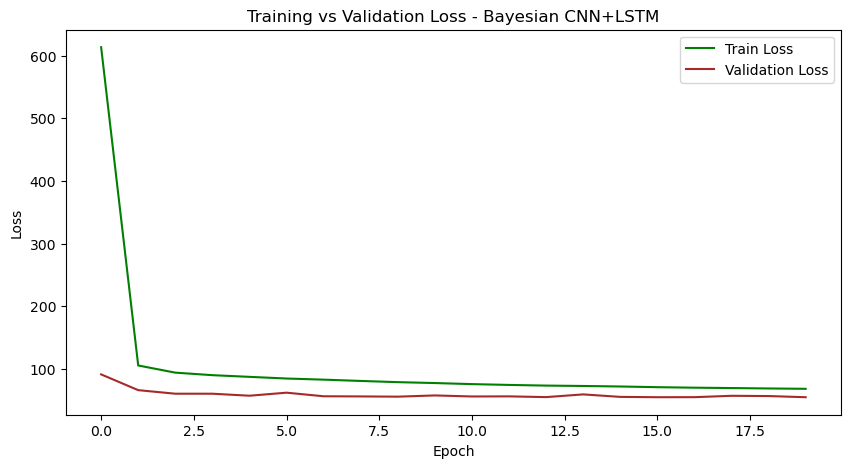

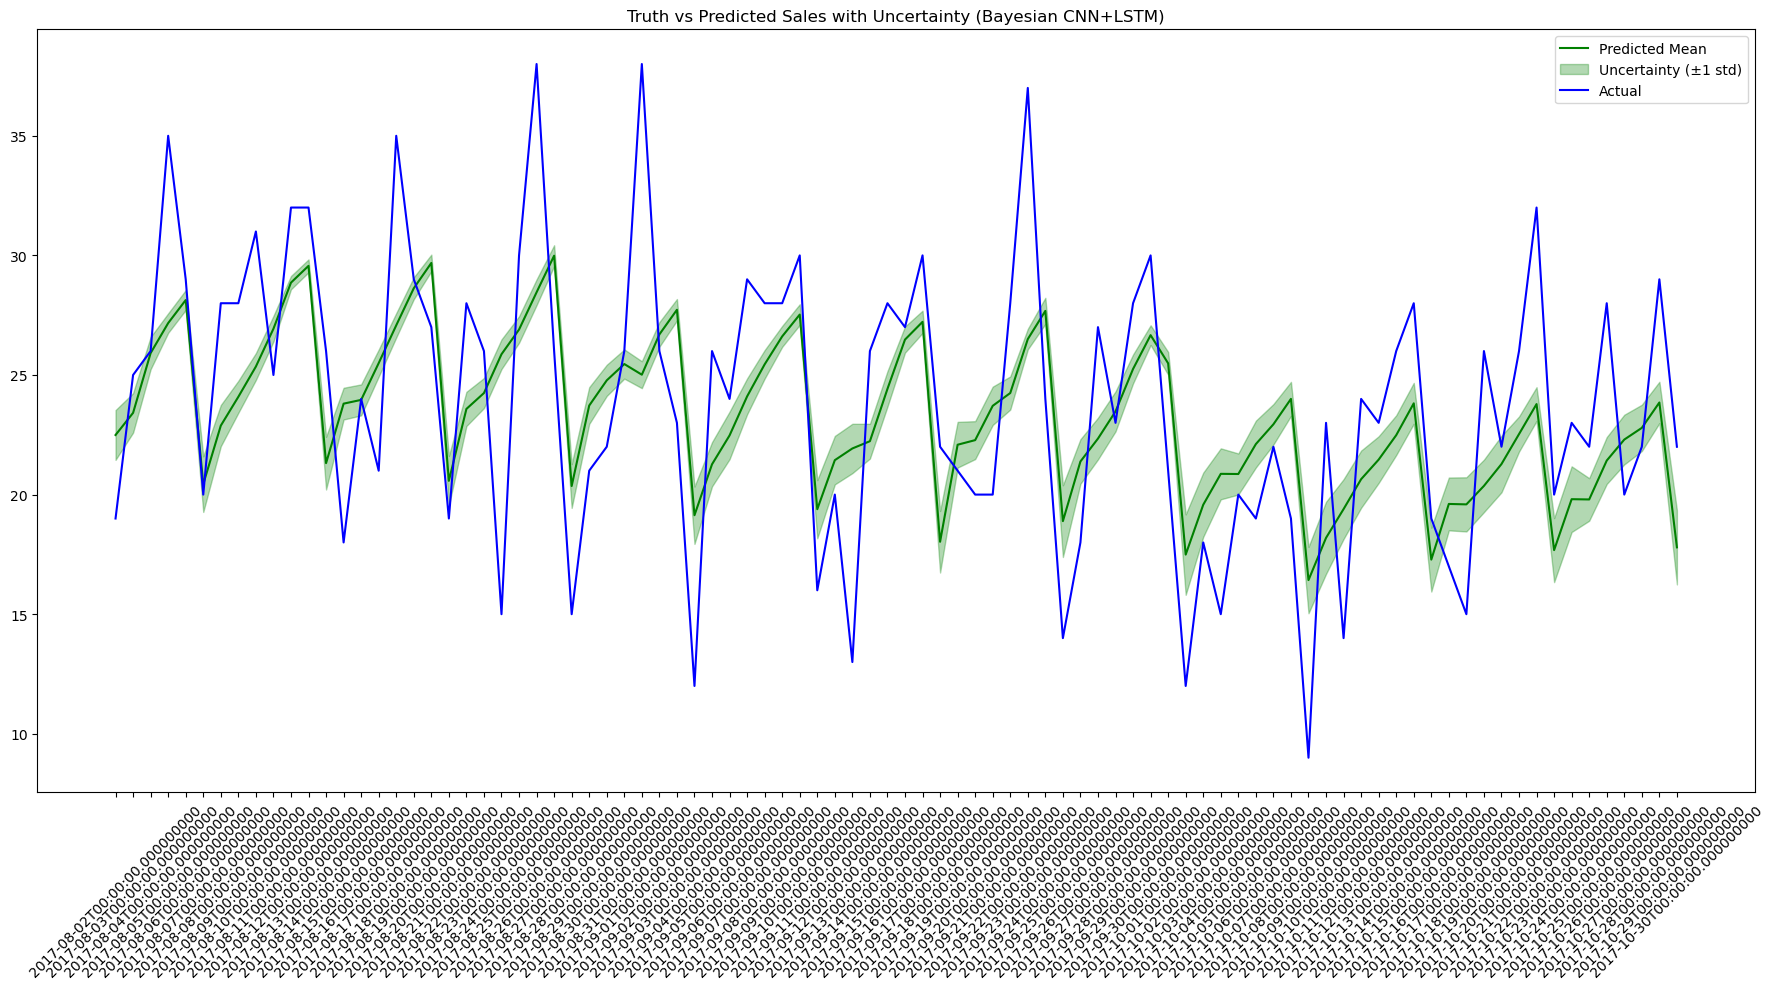

In [30]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Device and seed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# --- Define Bayesian CNN + LSTM ---
class BayesianCNNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=42, dropout_rate=0.3):
        super(BayesianCNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=32, hidden_size=hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # CNN expects input shape: (batch, channels, seq_len)
        x = x.permute(0, 2, 1)  # (B, F, T) for Conv1d
        x = self.conv1(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # (B, T, F) for LSTM

        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Last time step
        out = self.dropout(out)
        out = self.fc(out)
        return out

# --- Monte Carlo Dropout ---
def predict_mc(model, x, n_iter=50):
    model.train()  # keep dropout active
    preds = [model(x).detach().cpu().numpy() for _ in range(n_iter)]
    preds = np.stack(preds)
    return preds.mean(axis=0), preds.std(axis=0)

# --- Convert to Torch Tensor safely ---
def to_tensor(data, expect_3d=False):
    if isinstance(data, (pd.Series, pd.DataFrame)):
        data = data.to_numpy()
    tensor = torch.tensor(data, dtype=torch.float32)
    if expect_3d and tensor.ndim == 2:
        tensor = tensor.unsqueeze(-1)
    return tensor.to(device)

# === Replace these with your actual dataset ===
# x_train_series_v2, y_train_v2, x_val_series_v2, y_val_v2, x_test_v2, y_test_v2, y_date

# --- Prepare Data ---
X_train = to_tensor(x_train_series_v2, expect_3d=True)
y_train = to_tensor(y_train_v2).view(-1, 1)

X_val = to_tensor(x_val_series_v2, expect_3d=True)
y_val = to_tensor(y_val_v2).view(-1, 1)

X_test = to_tensor(x_test_v2, expect_3d=True)
y_test = to_tensor(y_test_v2).view(-1, 1)

# --- Model Setup ---
input_size = X_train.shape[2]
model = BayesianCNNLSTM(input_size=input_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# --- Training Loop ---
epochs = 20
batch_size = 128
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train.size(0))
    total_loss = 0

    for i in range(0, X_train.size(0), batch_size):
        idx = permutation[i:i + batch_size]
        xb, yb = X_train[idx], y_train[idx]

        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val).item()

    avg_train_loss = total_loss / (X_train.size(0) // batch_size)
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

# --- Monte Carlo Predictions ---
y_pred_mean, y_pred_std = predict_mc(model, X_test, n_iter=50)
y_true_np = y_test.cpu().numpy()

# --- Evaluation ---
print("Bayesian CNN+LSTM RMSE:", np.sqrt(mean_squared_error(y_true_np, y_pred_mean)))
print("Bayesian CNN+LSTM R2 Score:", r2_score(y_true_np, y_pred_mean))
print("Bayesian CNN+LSTM MAE:", mean_absolute_error(y_true_np, y_pred_mean))
print("Bayesian CNN+LSTM MAPE:", mean_absolute_percentage_error(y_true_np, y_pred_mean))
print("Bayesian CNN+LSTM MSE:", mean_squared_error(y_true_np, y_pred_mean))

# --- Plot: Training and Validation Loss ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='green')
plt.plot(val_losses, label='Validation Loss', color='brown')
plt.title("Training vs Validation Loss - Bayesian CNN+LSTM")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# --- Plot: Predictions with Uncertainty ---
plt.figure(figsize=(18, 10))
x_plot = np.array(y_date[:90]).astype(str)

plt.plot(x_plot, y_pred_mean[:90], label='Predicted Mean', color='green')
plt.fill_between(x_plot,
                 (y_pred_mean - y_pred_std)[:90, 0],
                 (y_pred_mean + y_pred_std)[:90, 0],
                 color='green', alpha=0.3, label='Uncertainty (±1 std)')
plt.plot(x_plot, y_test_v2[:90], label='Actual', color='blue')
plt.title('Truth vs Predicted Sales with Uncertainty (Bayesian CNN+LSTM)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Optuna based Bayesian CNN+LSTM

In [25]:
import numpy as np

def to_numpy_3d(X):
    """Ensure (samples, timesteps, features). If DF with (samples, timesteps), add feature dim=1."""
    if hasattr(X, "to_numpy"):
        X = X.to_numpy()
    if X.ndim == 2:
        X = X.reshape(X.shape[0], X.shape[1], 1)
    return X

def to_cnnlstm_subseq(X, subsequences):
    """Convert to (samples, subsequences, timesteps_per_subseq, features)."""
    X = X.to_numpy() if hasattr(X, "to_numpy") else X
    if X.ndim == 2:
        samples, timesteps = X.shape
        features = 1
        X = X.reshape(samples, timesteps, features)
    elif X.ndim == 3:
        samples, timesteps, features = X.shape
    else:
        raise ValueError(f"Unexpected shape: {X.shape}")

    assert timesteps % subsequences == 0, (
        f"Timesteps ({timesteps}) must be divisible by subsequences ({subsequences})"
    )
    t_per = timesteps // subsequences
    return X.reshape(samples, subsequences, t_per, features)

# Adjust subsequences to match your earlier CNN+LSTM setup
subsequences = 2  

# Create the training/validation/test arrays in CNN+LSTM format
x_train_series_sub     = to_cnnlstm_subseq(x_train_v2, subsequences)
x_val_series_sub       = to_cnnlstm_subseq(x_val_v2, subsequences)
x_test_v2_series_sub   = to_cnnlstm_subseq(x_test_v2, subsequences)

print("Train set shape:", x_train_series_sub.shape)
print("Validation set shape:", x_val_series_sub.shape)
print("Test set shape:", x_test_v2_series_sub.shape)


Train set shape: (669200, 2, 21, 1)
Validation set shape: (167300, 2, 21, 1)
Test set shape: (76000, 2, 21, 1)


In [33]:
!pip install optuna tensorflow

import numpy as np
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Safe MAPE fallback (older sklearn may lack it)
try:
    from sklearn.metrics import mean_absolute_percentage_error
except Exception:
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        eps = np.finfo(float).eps
        return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps)))

# ========= 1) Model factory (UNCHANGED architecture) =========
def build_cnn_lstm(subsequences, t_per, features, lr=0.0003):
    model = Sequential()
    model.add(
        TimeDistributed(
            Conv1D(filters=64, kernel_size=1, activation='relu'),
            input_shape=(subsequences, t_per, features)
        )
    )
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(learning_rate=lr))
    return model

# ========= 2) Ensemble (UNCHANGED logic) =========
def cnn_lstm_ensemble(
    x_train, y_train, x_val, y_val, x_test,
    subsequences, t_per, features,
    n_models=20, epochs=40, batch_size=256, lr=0.0003,
    bootstrap=True, seed=42, verbose=0
):
    rng = np.random.default_rng(seed)
    n = x_train.shape[0]

    preds_val_all = []
    preds_test_all = []

    for m in range(n_models):
        # different seeds per model
        tf.keras.utils.set_random_seed(seed + m)
        tf.random.set_seed(seed + m)
        np.random.seed(seed + m)

        # optional bootstrap resampling
        if bootstrap:
            idx = rng.integers(0, n, size=n)
            xb, yb = x_train[idx], y_train[idx]
        else:
            xb, yb = x_train, y_train

        model = build_cnn_lstm(subsequences, t_per, features, lr=lr)
        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
        model.fit(
            xb, yb,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[es],
            verbose=verbose
        )

        preds_val = model.predict(x_val,  verbose=0).reshape(-1)
        preds_test = model.predict(x_test, verbose=0).reshape(-1)

        preds_val_all.append(preds_val)
        preds_test_all.append(preds_test)

    preds_val_all = np.stack(preds_val_all, axis=0)   # (M, N_val)
    preds_test_all = np.stack(preds_test_all, axis=0) # (M, N_test)

    out = {
        "val_mean": preds_val_all.mean(axis=0),
        "val_std":  preds_val_all.std(axis=0),
        "test_mean": preds_test_all.mean(axis=0),
        "test_std":  preds_test_all.std(axis=0),
        "val_all": preds_val_all,
        "test_all": preds_test_all
    }
    return out

# ========= 3) Optuna objective: tune lr / batch_size / epochs (no arch changes) =========
# Infer shape from your tensors
subsequences = x_train_series_sub.shape[1]
t_per       = x_train_series_sub.shape[2]
features    = x_train_series_sub.shape[3]

def objective(trial):
    # Suggest training hyperparameters (keep architecture fixed)
    lr = trial.suggest_float('lr', 1e-4, 3e-3, log=True)           # around your 3e-4
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    max_epochs = trial.suggest_int('epochs', 20, 80)

    # build and train single model with EarlyStopping
    tf.keras.utils.set_random_seed(42 + trial.number)
    model = build_cnn_lstm(subsequences, t_per, features, lr=lr)
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    model.fit(
        x_train_series_sub, y_train,
        validation_data=(x_val_series_sub, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    # evaluate on validation using MAE (optimize this)
    val_pred = model.predict(x_val_series_sub, verbose=0).reshape(-1)
    val_mae = mean_absolute_error(y_val, val_pred)
    # Optionally log extra metrics
    trial.set_user_attr("val_rmse", float(np.sqrt(mean_squared_error(y_val, val_pred))))
    trial.set_user_attr("val_r2",   float(r2_score(y_val, val_pred)))
    trial.set_user_attr("val_mape", float(mean_absolute_percentage_error(y_val, val_pred)))
    trial.set_user_attr("val_mse",  float(mean_squared_error(y_val, val_pred)))
    return val_mae

# Run Optuna (efficient number of trials)
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=30, show_progress_bar=False)

print("\n=== Optuna: Best Validation MAE ===")
print(study.best_value)
print("\n=== Optuna: Best Params ===")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

# ========= 4) Retrain BEST single model and report metrics =========
best_lr        = study.best_params['lr']
best_batch     = study.best_params['batch_size']
best_epochs    = study.best_params['epochs']

tf.keras.utils.set_random_seed(2025)
best_model = build_cnn_lstm(subsequences, t_per, features, lr=best_lr)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
best_model.fit(
    x_train_series_sub, y_train,
    validation_data=(x_val_series_sub, y_val),
    epochs=best_epochs,
    batch_size=best_batch,
    callbacks=[es],
    verbose=0
)

val_pred_best  = best_model.predict(x_val_series_sub,  verbose=0).reshape(-1)
test_pred_best = best_model.predict(x_test_v2_series_sub, verbose=0).reshape(-1)

print("\n=== Best Single Model: Validation Metrics ===")
print("MSE :", mean_squared_error(y_val, val_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_val, val_pred_best)))
print("R2  :", r2_score(y_val, val_pred_best))
print("MAE :", mean_absolute_error(y_val, val_pred_best))
print("MAPE:", mean_absolute_percentage_error(y_val, val_pred_best))

print("\n=== Best Single Model: Test Metrics ===")
print("MSE :", mean_squared_error(y_test, test_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_test, test_pred_best)))
print("R2  :", r2_score(y_test, test_pred_best))
print("MAE :", mean_absolute_error(y_test, test_pred_best))
print("MAPE:", mean_absolute_percentage_error(y_test, test_pred_best))

# ========= 5) Re-run your ENSEMBLE using tuned training hyperparams =========
ens = cnn_lstm_ensemble(
    x_train_series_sub, y_train,
    x_val_series_sub,   y_val,
    x_test_v2_series_sub,
    subsequences=subsequences, t_per=t_per, features=features,
    n_models=20,
    epochs=best_epochs,
    batch_size=best_batch,
    lr=best_lr,
    bootstrap=True,
    seed=42, verbose=0
)

y_pred_mean_val  = ens["val_mean"]
y_pred_mean_test = ens["test_mean"]

print("\n=== Ensemble (Tuned HPs): Validation Metrics (Mean) ===")
print("MSE :", mean_squared_error(y_val, y_pred_mean_val))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_mean_val)))
print("R2  :", r2_score(y_val, y_pred_mean_val))
print("MAE :", mean_absolute_error(y_val, y_pred_mean_val))
print("MAPE:", mean_absolute_percentage_error(y_val, y_pred_mean_val))

print("\n=== Ensemble (Tuned HPs): Test Metrics (Mean) ===")
print("MSE :", mean_squared_error(y_test, y_pred_mean_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mean_test)))
print("R2  :", r2_score(y_test, y_pred_mean_test))
print("MAE :", mean_absolute_error(y_test, y_pred_mean_test))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_mean_test))

# ========= 6) Uncertainty bands (empirical percentiles) =========
test_all = ens["test_all"]  # (M, N_test)
p05 = np.percentile(test_all, 5, axis=0)
p95 = np.percentile(test_all, 95, axis=0)
p10 = np.percentile(test_all, 10, axis=0)
p90 = np.percentile(test_all, 90, axis=0)

plt.figure(figsize=(18, 9))
x_plot = np.array(y_date).astype(str)

plt.plot(x_plot, y_pred_mean_test, label='Predicted Mean (CNN-LSTM Ensemble, tuned)', linewidth=2)
plt.plot(x_plot, y_test,           label='Actual', linewidth=2)

plt.fill_between(x_plot, p10, p90, alpha=0.12, label='80% PI (10–90%)')
plt.fill_between(x_plot, p05, p95, alpha=0.08, label='90% PI (5–95%)')

plt.title("CNN-LSTM Ensemble (Optuna-Tuned) Forecast with Uncertainty Bands")
plt.xlabel("Date"); plt.ylabel("Target")
plt.xticks(rotation=45); plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(); plt.tight_layout(); plt.show()


Defaulting to user installation because normal site-packages is not writeable


[I 2025-08-15 17:01:41,041] A new study created in memory with name: no-name-6def504d-8c5c-4f1a-8ca8-0794f4abdea0
2025-08-15 17:01:41.062790: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
[I 2025-08-15 17:19:33,852] Trial 0 finished with value: 5.90627384185791 and parameters: {'lr': 0.0003574712922600243, 'batch_size': 128, 'epochs': 29}. Best is trial 0 with value: 5.90627384185791.
[I 2025-08-15 17:25:21,365] Trial 1 finished with value: 5.99735164642334 and parameters: {'lr': 0.00016998978382700775, 'batch_size': 256, 'epochs': 63}. Best is trial 0 with value: 5.90627384185791.
[I 2025-08-15 17:44:22,823] Trial 2 finished with value: 5.811179161071777 and parameters: {'lr': 0.00010725209743172001, 'batch_size': 128, 'epochs': 31}. Best is trial 2 with value: 5.811179161071777.
[W 2025-08-15 17:53:33,735] Trial 3 failed with parameters: {'lr': 0.00018659959624904942, 'batch_s

KeyboardInterrupt: 

In [34]:
# !pip install optuna tensorflow

import numpy as np
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

try:
    from sklearn.metrics import mean_absolute_percentage_error
except Exception:
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
        eps = np.finfo(float).eps
        return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps)))

# --- Assumes x_train_series_sub, x_val_series_sub, x_test_v2_series_sub, y_train, y_val, y_test are ready ---
subsequences = x_train_series_sub.shape[1]
t_per       = x_train_series_sub.shape[2]
features    = x_train_series_sub.shape[3]

def build_cnn_lstm(lr=3e-4):
    model = Sequential([
        TimeDistributed(Conv1D(64, 1, activation='relu'), input_shape=(subsequences, t_per, features)),
        TimeDistributed(MaxPooling1D(pool_size=2)),
        TimeDistributed(Flatten()),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer=Adam(learning_rate=lr))
    return model

def objective(trial):
    lr         = trial.suggest_float('lr', 1e-4, 3e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256, 512])
    epochs     = trial.suggest_int('epochs', 20, 80)

    tf.keras.utils.set_random_seed(42 + trial.number)
    model = build_cnn_lstm(lr=lr)
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    model.fit(x_train_series_sub, y_train,
              validation_data=(x_val_series_sub, y_val),
              epochs=epochs, batch_size=batch_size,
              callbacks=[es], verbose=0)

    val_pred = model.predict(x_val_series_sub, verbose=0).reshape(-1)
    return mean_absolute_error(y_val, val_pred)  # optimize MAE

# --- Run Optuna (compact) ---
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=25, show_progress_bar=False)

print("\nBest Validation MAE:", study.best_value)
print("Best Params:", study.best_params)

# --- Retrain best single model + evaluate ---
best_lr     = study.best_params['lr']
best_batch  = study.best_params['batch_size']
best_epochs = study.best_params['epochs']

tf.keras.utils.set_random_seed(2025)
best_model = build_cnn_lstm(lr=best_lr)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
best_model.fit(x_train_series_sub, y_train,
               validation_data=(x_val_series_sub, y_val),
               epochs=best_epochs, batch_size=best_batch,
               callbacks=[es], verbose=0)

val_pred  = best_model.predict(x_val_series_sub,  verbose=0).reshape(-1)
test_pred = best_model.predict(x_test_v2_series_sub, verbose=0).reshape(-1)

print("\nBest Single Model — Validation:")
print("MSE :", mean_squared_error(y_val, val_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_val, val_pred)))
print("R2  :", r2_score(y_val, val_pred))
print("MAE :", mean_absolute_error(y_val, val_pred))
print("MAPE:", mean_absolute_percentage_error(y_val, val_pred))

print("\nBest Single Model — Test:")
print("MSE :", mean_squared_error(y_test, test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, test_pred)))
print("R2  :", r2_score(y_test, test_pred))
print("MAE :", mean_absolute_error(y_test, test_pred))
print("MAPE:", mean_absolute_percentage_error(y_test, test_pred))

# --- (Optional) Use best settings in your existing ensemble call ---
# ens = cnn_lstm_ensemble(x_train_series_sub, y_train, x_val_series_sub, y_val, x_test_v2_series_sub,
#                         subsequences=subsequences, t_per=t_per, features=features,
#                         n_models=20, epochs=best_epochs, batch_size=best_batch, lr=best_lr,
#                         bootstrap=True, seed=42, verbose=0)


[I 2025-08-15 17:53:42,870] A new study created in memory with name: no-name-14d28fde-53b6-4941-a086-5ce7d65c4f9f
[I 2025-08-15 18:11:45,315] Trial 0 finished with value: 5.90627384185791 and parameters: {'lr': 0.0003574712922600243, 'batch_size': 128, 'epochs': 29}. Best is trial 0 with value: 5.90627384185791.
[I 2025-08-15 18:17:35,646] Trial 1 finished with value: 5.99735164642334 and parameters: {'lr': 0.00016998978382700775, 'batch_size': 256, 'epochs': 63}. Best is trial 0 with value: 5.90627384185791.
[I 2025-08-15 18:36:55,499] Trial 2 finished with value: 5.811179161071777 and parameters: {'lr': 0.00010725209743172001, 'batch_size': 128, 'epochs': 31}. Best is trial 2 with value: 5.811179161071777.
[I 2025-08-15 18:51:41,486] Trial 3 finished with value: 5.792365074157715 and parameters: {'lr': 0.00018659959624904942, 'batch_size': 256, 'epochs': 37}. Best is trial 3 with value: 5.792365074157715.
[I 2025-08-15 18:57:55,188] Trial 4 finished with value: 6.014888286590576 and 


Best Validation MAE: 5.770389556884766
Best Params: {'lr': 0.00010126107669156147, 'batch_size': 128, 'epochs': 57}

Best Single Model — Validation:
MSE : 59.879242
RMSE: 7.738168
R2  : 0.9268461598623254
MAE : 5.9278173
MAPE: 299593760000.0

Best Single Model — Test:
MSE : 77.67648
RMSE: 8.813426
R2  : 0.9153129881477944
MAE : 6.6882663
MAPE: 0.1337415


## new one for less time (not tried yet)

In [ ]:
# !pip install optuna tensorflow

import numpy as np
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# ==== Safe MAPE ====
try:
    from sklearn.metrics import mean_absolute_percentage_error
except Exception:
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        eps = np.finfo(float).eps
        return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps)))

# ------------------------------------------------
# 0) Ensure inputs are reshaped for CNN+LSTM once
# ------------------------------------------------
def to_cnnlstm_subseq(X, subsequences=2):
    X = X.to_numpy() if hasattr(X, "to_numpy") else X
    if X.ndim == 2:
        N, T = X.shape
        F = 1
        X = X.reshape(N, T, F)
    elif X.ndim == 3:
        N, T, F = X.shape
    else:
        raise ValueError(f"Unexpected shape: {X.shape}")
    assert T % subsequences == 0, f"Timesteps {T} not divisible by subsequences {subsequences}"
    t_per = T // subsequences
    return X.reshape(N, subsequences, t_per, F)

# If these vars aren't already defined in your session, create them now:
try:
    _ = x_train_series_sub
except NameError:
    subsequences = 2
    x_train_series_sub   = to_cnnlstm_subseq(x_train_v2, subsequences)
    x_val_series_sub     = to_cnnlstm_subseq(x_val_v2, subsequences)
    x_test_v2_series_sub = to_cnnlstm_subseq(x_test_v2, subsequences)

# Infer shapes
subsequences = x_train_series_sub.shape[1]
t_per       = x_train_series_sub.shape[2]
features    = x_train_series_sub.shape[3]

# ------------------------------------------------
# 1) Model factory (keeps flow; knobs exposed via args)
# ------------------------------------------------
def build_cnn_lstm(
    subsequences, t_per, features, lr=3e-4,
    filters=64, kernel_size=1, pool_size=2,
    lstm_units=50, dropout_rate=0.0
):
    model = Sequential()
    model.add(TimeDistributed(
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
        input_shape=(subsequences, t_per, features)
    ))
    # pool_size must be <= t_per after conv; safeguard:
    ps = min(pool_size, max(1, t_per))
    model.add(TimeDistributed(MaxPooling1D(pool_size=ps)))
    model.add(TimeDistributed(Flatten()))
    if dropout_rate and dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(learning_rate=lr))
    return model

# ------------------------------------------------
# 2) Ensemble logic (unchanged)
# ------------------------------------------------
def cnn_lstm_ensemble(
    x_train, y_train, x_val, y_val, x_test,
    subsequences, t_per, features,
    n_models=20, epochs=40, batch_size=256, lr=0.0003,
    filters=64, kernel_size=1, pool_size=2, lstm_units=50, dropout_rate=0.0,
    bootstrap=True, seed=42, verbose=0
):
    rng = np.random.default_rng(seed)
    n = x_train.shape[0]

    preds_val_all = []
    preds_test_all = []

    for m in range(n_models):
        tf.keras.utils.set_random_seed(seed + m)
        tf.random.set_seed(seed + m)
        np.random.seed(seed + m)

        if bootstrap:
            idx = rng.integers(0, n, size=n)
            xb, yb = x_train[idx], y_train[idx]
        else:
            xb, yb = x_train, y_train

        model = build_cnn_lstm(subsequences, t_per, features, lr=lr,
                               filters=filters, kernel_size=kernel_size, pool_size=pool_size,
                               lstm_units=lstm_units, dropout_rate=dropout_rate)
        es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
        model.fit(xb, yb,
                  validation_data=(x_val, y_val),
                  epochs=epochs, batch_size=batch_size,
                  callbacks=[es], verbose=verbose)

        preds_val_all.append(model.predict(x_val,  verbose=0).reshape(-1))
        preds_test_all.append(model.predict(x_test, verbose=0).reshape(-1))

    preds_val_all = np.stack(preds_val_all, axis=0)
    preds_test_all = np.stack(preds_test_all, axis=0)

    return {
        "val_mean": preds_val_all.mean(axis=0),
        "val_std":  preds_val_all.std(axis=0),
        "test_mean": preds_test_all.mean(axis=0),
        "test_std":  preds_test_all.std(axis=0),
        "val_all": preds_val_all,
        "test_all": preds_test_all
    }

# ------------------------------------------------
# 3) Optuna objective with wider, meaningful ranges
#    Toggle TUNE_ARCH for architecture knobs
# ------------------------------------------------
TUNE_ARCH = False  # set True to also search filters/kernel/lstm/dropout/pool

def objective(trial):
    # training hyperparams (always tuned)
    lr         = trial.suggest_float('lr', 1e-4, 3e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    max_epochs = trial.suggest_int('epochs', 20, 100)

    # architecture knobs (optional)
    if TUNE_ARCH:
        filters     = trial.suggest_categorical('filters', [32, 64, 96, 128])
        kernel_size = trial.suggest_categorical('kernel_size', [1, 2, 3, 5])
        pool_size   = trial.suggest_categorical('pool_size', [1, 2])
        lstm_units  = trial.suggest_categorical('lstm_units', [32, 50, 64, 96, 128])
        dropout_rate= trial.suggest_float('dropout_rate', 0.0, 0.5)
    else:
        filters, kernel_size, pool_size, lstm_units, dropout_rate = 64, 1, 2, 50, 0.0

    # build & train
    tf.keras.utils.set_random_seed(42 + trial.number)
    model = build_cnn_lstm(subsequences, t_per, features, lr=lr,
                           filters=filters, kernel_size=kernel_size,
                           pool_size=pool_size, lstm_units=lstm_units,
                           dropout_rate=dropout_rate)
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    model.fit(x_train_series_sub, y_train,
              validation_data=(x_val_series_sub, y_val),
              epochs=max_epochs, batch_size=batch_size,
              callbacks=[es], verbose=0)

    # evaluate on validation
    val_pred = model.predict(x_val_series_sub, verbose=0).reshape(-1)
    val_mae  = mean_absolute_error(y_val, val_pred)
    # track extra metrics
    trial.set_user_attr("val_rmse", float(np.sqrt(mean_squared_error(y_val, val_pred))))
    trial.set_user_attr("val_r2",   float(r2_score(y_val, val_pred)))
    trial.set_user_attr("val_mape", float(mean_absolute_percentage_error(y_val, val_pred)))
    trial.set_user_attr("val_mse",  float(mean_squared_error(y_val, val_pred)))
    return val_mae

# Run Optuna
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=40, show_progress_bar=False)

print("\n=== Optuna: Best Validation MAE ===")
print(study.best_value)
print("\n=== Optuna: Best Params ===")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

# Extract tuned params
best_lr        = study.best_params.get('lr', 3e-4)
best_batch     = study.best_params.get('batch_size', 256)
best_epochs    = study.best_params.get('epochs', 40)
best_filters   = study.best_params.get('filters', 64 if TUNE_ARCH else 64)
best_kernel    = study.best_params.get('kernel_size', 1 if TUNE_ARCH else 1)
best_pool      = study.best_params.get('pool_size', 2 if TUNE_ARCH else 2)
best_lstm      = study.best_params.get('lstm_units', 50 if TUNE_ARCH else 50)
best_dropout   = study.best_params.get('dropout_rate', 0.0 if TUNE_ARCH else 0.0)

# ------------------------------------------------
# 4) Retrain best single model & evaluate
# ------------------------------------------------
tf.keras.utils.set_random_seed(2025)
best_model = build_cnn_lstm(subsequences, t_per, features, lr=best_lr,
                            filters=best_filters, kernel_size=best_kernel,
                            pool_size=best_pool, lstm_units=best_lstm,
                            dropout_rate=best_dropout)
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
best_model.fit(x_train_series_sub, y_train,
               validation_data=(x_val_series_sub, y_val),
               epochs=best_epochs, batch_size=best_batch,
               callbacks=[es], verbose=0)

val_pred_best  = best_model.predict(x_val_series_sub,  verbose=0).reshape(-1)
test_pred_best = best_model.predict(x_test_v2_series_sub, verbose=0).reshape(-1)

print("\n=== Best Single Model: Validation Metrics ===")
print("MSE :", mean_squared_error(y_val, val_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_val, val_pred_best)))
print("R2  :", r2_score(y_val, val_pred_best))
print("MAE :", mean_absolute_error(y_val, val_pred_best))
print("MAPE:", mean_absolute_percentage_error(y_val, val_pred_best))

print("\n=== Best Single Model: Test Metrics ===")
print("MSE :", mean_squared_error(y_test, test_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_test, test_pred_best)))
print("R2  :", r2_score(y_test, test_pred_best))
print("MAE :", mean_absolute_error(y_test, test_pred_best))
print("MAPE:", mean_absolute_percentage_error(y_test, test_pred_best))

# ------------------------------------------------
# 5) Re-run ENSEMBLE using tuned TRAINING hyperparams
#     (architecture only follows if TUNE_ARCH=True)
# ------------------------------------------------
ens = cnn_lstm_ensemble(
    x_train_series_sub, y_train,
    x_val_series_sub,   y_val,
    x_test_v2_series_sub,
    subsequences=subsequences, t_per=t_per, features=features,
    n_models=20,
    epochs=best_epochs,
    batch_size=best_batch,
    lr=best_lr,
    filters=best_filters, kernel_size=best_kernel,
    pool_size=best_pool, lstm_units=best_lstm,
    dropout_rate=best_dropout if TUNE_ARCH else 0.0,
    bootstrap=True, seed=42, verbose=0
)

y_pred_mean_val  = ens["val_mean"]
y_pred_mean_test = ens["test_mean"]

print("\n=== Ensemble (Tuned): Validation Metrics (Mean) ===")
print("MSE :", mean_squared_error(y_val, y_pred_mean_val))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_mean_val)))
print("R2  :", r2_score(y_val, y_pred_mean_val))
print("MAE :", mean_absolute_error(y_val, y_pred_mean_val))
print("MAPE:", mean_absolute_percentage_error(y_val, y_pred_mean_val))

print("\n=== Ensemble (Tuned): Test Metrics (Mean) ===")
print("MSE :", mean_squared_error(y_test, y_pred_mean_test))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_mean_test)))
print("R2  :", r2_score(y_test, y_pred_mean_test))
print("MAE :", mean_absolute_error(y_test, y_pred_mean_test))
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_mean_test))

# ------------------------------------------------
# 6) Uncertainty bands
# ------------------------------------------------
test_all = ens["test_all"]
p05 = np.percentile(test_all, 5, axis=0)
p95 = np.percentile(test_all, 95, axis=0)
p10 = np.percentile(test_all, 10, axis=0)
p90 = np.percentile(test_all, 90, axis=0)

plt.figure(figsize=(18, 9))
x_plot = np.array(y_date).astype(str)
plt.plot(x_plot, y_pred_mean_test, label='Predicted Mean (CNN-LSTM Ensemble, tuned)', linewidth=2)
plt.plot(x_plot, y_test,           label='Actual', linewidth=2)
plt.fill_between(x_plot, p10, p90, alpha=0.12, label='80% PI (10–90%)')
plt.fill_between(x_plot, p05, p95, alpha=0.08, label='90% PI (5–95%)')
plt.title("CNN-LSTM Ensemble (Optuna-Tuned) Forecast with Uncertainty")
plt.xlabel("Date"); plt.ylabel("Target")
plt.xticks(rotation=45); plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(); plt.tight_layout(); plt.show()


## Optuna tuning with architecture

In [ ]:
# !pip install optuna tensorflow

import numpy as np
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    TimeDistributed, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
    Flatten, LSTM, Dense, Dropout, Bidirectional, LayerNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# ---- Safe MAPE ----
try:
    from sklearn.metrics import mean_absolute_percentage_error
except Exception:
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
        eps = np.finfo(float).eps
        return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps)))

# ====================== Shapes from your prepared tensors ======================
subsequences = x_train_series_sub.shape[1]
t_per       = x_train_series_sub.shape[2]
features    = x_train_series_sub.shape[3]

# ====================== Model factory driven by Optuna trial ======================
def build_cnn_lstm_trial(trial):
    # ---- Training hparams ----
    lr         = trial.suggest_float('lr', 1e-4, 3e-3, log=True)
    # (We return lr to the caller; model only needs the compiled optimizer)
    # ---- Architecture hparams ----
    filters1      = trial.suggest_categorical('filters1', [32, 48, 64, 96, 128])
    kernel_size1  = trial.suggest_categorical('kernel_size1', [1, 2, 3, 5])
    use_conv2     = trial.suggest_categorical('use_conv2', [False, True])
    if use_conv2:
        filters2     = trial.suggest_categorical('filters2', [32, 48, 64, 96, 128])
        kernel_size2 = trial.suggest_categorical('kernel_size2', [1, 2, 3, 5])
    else:
        filters2, kernel_size2 = None, None

    pool_size     = trial.suggest_categorical('pool_size', [1, 2])
    flatten_strategy = trial.suggest_categorical('flatten', ['flatten', 'gap'])  # your original was 'flatten'

    lstm_units    = trial.suggest_categorical('lstm_units', [32, 48, 64, 96, 128])
    bidir         = trial.suggest_categorical('bidirectional', [False, True])
    recurrent_do  = trial.suggest_float('recurrent_dropout', 0.0, 0.4)
    dropout_rate  = trial.suggest_float('dropout_rate', 0.0, 0.5)
    dense_units   = trial.suggest_categorical('dense_units', [0, 32, 64, 96, 128])  # 0 = no extra dense
    use_ln        = trial.suggest_categorical('layer_norm', [False, True])

    # ---- Build model ----
    model = Sequential()

    # Conv block 1
    model.add(TimeDistributed(
        Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu'),
        input_shape=(subsequences, t_per, features)
    ))

    # Optional Conv block 2
    if use_conv2:
        model.add(TimeDistributed(Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu')))

    # Safe pool size
    ps = min(pool_size, max(1, t_per))
    model.add(TimeDistributed(MaxPooling1D(pool_size=ps)))

    # Optional LayerNorm across features after conv stack
    if use_ln:
        model.add(TimeDistributed(LayerNormalization()))

    # Feature aggregator
    if flatten_strategy == 'gap':
        model.add(TimeDistributed(GlobalAveragePooling1D()))
    else:
        model.add(TimeDistributed(Flatten()))

    # Recurrent block
    if bidir:
        model.add(Bidirectional(LSTM(lstm_units, activation='relu', recurrent_dropout=recurrent_do)))
    else:
        model.add(LSTM(lstm_units, activation='relu', recurrent_dropout=recurrent_do))

    # Optional hidden dense head
    if dense_units and dense_units > 0:
        model.add(Dense(dense_units, activation='relu'))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
    elif dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # Output
    model.add(Dense(1))

    model.compile(loss='mse', optimizer=Adam(learning_rate=lr))
    return model, lr

# ====================== Optuna objective ======================
def objective(trial):
    # Training hparams
    batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])
    max_epochs = trial.suggest_int('epochs', 30, 120)

    tf.keras.utils.set_random_seed(42 + trial.number)
    model, lr = build_cnn_lstm_trial(trial)

    # Optuna pruning + early stopping
    es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=0)
    model.fit(
        x_train_series_sub, y_train,
        validation_data=(x_val_series_sub, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    # Validation MAE as the optimization target (robust for scale/outliers)
    val_pred = model.predict(x_val_series_sub, verbose=0).reshape(-1)
    val_mae  = mean_absolute_error(y_val, val_pred)

    # Log extra metrics for inspection
    trial.set_user_attr("val_rmse", float(np.sqrt(mean_squared_error(y_val, val_pred))))
    trial.set_user_attr("val_r2",   float(r2_score(y_val, val_pred)))
    trial.set_user_attr("val_mape", float(mean_absolute_percentage_error(y_val, val_pred)))
    trial.set_user_attr("val_mse",  float(mean_squared_error(y_val, val_pred)))
    return val_mae

# ====================== Run Optuna ======================
study = optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=40, show_progress_bar=False)

print("\n=== Optuna: Best Validation MAE ===")
print(study.best_value)
print("\n=== Optuna: Best Params ===")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

# ====================== Retrain best single model & evaluate ======================
best_params = study.best_params

tf.keras.utils.set_random_seed(2025)
# Build model with best architecture
class DummyTrial:
    def __init__(self, d): self._d = d
    def suggest_float(self, k, *args, **kwargs):  return self._d[k]
    def suggest_categorical(self, k, choices):     return self._d[k]
    def suggest_int(self, k, *args, **kwargs):     return self._d[k]

best_trial = DummyTrial(best_params)
best_model, _ = build_cnn_lstm_trial(best_trial)

es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=0)
best_model.fit(
    x_train_series_sub, y_train,
    validation_data=(x_val_series_sub, y_val),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[es],
    verbose=0
)

val_pred_best  = best_model.predict(x_val_series_sub,  verbose=0).reshape(-1)
test_pred_best = best_model.predict(x_test_v2_series_sub, verbose=0).reshape(-1)

print("\n=== Best Single Model: Validation ===")
print("MSE :", mean_squared_error(y_val, val_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_val, val_pred_best)))
print("R2  :", r2_score(y_val, val_pred_best))
print("MAE :", mean_absolute_error(y_val, val_pred_best))
print("MAPE:", mean_absolute_percentage_error(y_val, val_pred_best))

print("\n=== Best Single Model: Test ===")
print("MSE :", mean_squared_error(y_test, test_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_test, test_pred_best)))
print("R2  :", r2_score(y_test, test_pred_best))
print("MAE :", mean_absolute_error(y_test, test_pred_best))
print("MAPE:", mean_absolute_percentage_error(y_test, test_pred_best))

# ====================== (Optional) Reuse best settings in your Bayesian ensemble ======================
def cnn_lstm_ensemble_best(
    x_train, y_train, x_val, y_val, x_test, n_models=20, bootstrap=True, seed=42, verbose=0
):
    rng = np.random.default_rng(seed)
    n = x_train.shape[0]
    preds_val_all, preds_test_all = [], []

    for m in range(n_models):
        tf.keras.utils.set_random_seed(seed + m)
        tf.random.set_seed(seed + m)
        np.random.seed(seed + m)

        if bootstrap:
            idx = rng.integers(0, n, size=n)
            xb, yb = x_train[idx], y_train[idx]
        else:
            xb, yb = x_train, y_train

        model, _ = build_cnn_lstm_trial(best_trial)
        es = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=0)
        model.fit(xb, yb,
                  validation_data=(x_val, y_val),
                  epochs=best_params['epochs'],
                  batch_size=best_params['batch_size'],
                  callbacks=[es], verbose=verbose)

        preds_val_all.append(model.predict(x_val,  verbose=0).reshape(-1))
        preds_test_all.append(model.predict(x_test, verbose=0).reshape(-1))

    preds_val_all  = np.stack(preds_val_all, axis=0)
    preds_test_all = np.stack(preds_test_all, axis=0)
    return {
        "val_mean": preds_val_all.mean(axis=0),
        "val_std":  preds_val_all.std(axis=0),
        "test_mean": preds_test_all.mean(axis=0),
        "test_std":  preds_test_all.std(axis=0),
        "val_all": preds_val_all,
        "test_all": preds_test_all
    }

# Uncomment to run the tuned ensemble:
# ens = cnn_lstm_ensemble_best(x_train_series_sub, y_train, x_val_series_sub, y_val, x_test_v2_series_sub,
#                              n_models=20, bootstrap=True, seed=42, verbose=0)
# y_pred_mean_test = ens["test_mean"]
# test_all = ens["test_all"]
# p05 = np.percentile(test_all, 5, axis=0); p95 = np.percentile(test_all, 95, axis=0)
# p10 = np.percentile(test_all, 10, axis=0); p90 = np.percentile(test_all, 90, axis=0)
# plt.figure(figsize=(18,9)); x_plot = np.array(y_date).astype(str)
# plt.plot(x_plot, y_pred_mean_test, label='Pred Mean (Ensemble tuned)')
# plt.plot(x_plot, y_test, label='Actual')
# plt.fill_between(x_plot, p10, p90, alpha=0.12, label='80% PI'); plt.fill_between(x_plot, p05, p95, alpha=0.08, label='90% PI')
# plt.legend(); plt.xticks(rotation=45); plt.grid(True, ls='--', alpha=0.5); plt.tight_layout(); plt.show()


[I 2025-08-16 23:01:22,108] A new study created in memory with name: no-name-58d0a178-aba9-4921-8213-ce073fe5e918


2025-08-16 23:01:22.119088: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
[I 2025-08-16 23:25:36,285] Trial 0 finished with value: 5.722477874664653 and parameters: {'batch_size': 128, 'epochs': 44, 'lr': 0.00016998978382700775, 'filters1': 48, 'kernel_size1': 1, 'use_conv2': True, 'filters2': 96, 'kernel_size2': 5, 'pool_size': 2, 'flatten': 'flatten', 'lstm_units': 128, 'bidirectional': False, 'recurrent_dropout': 0.039068845602553554, 'dropout_rate': 0.34211651325607845, 'dense_units': 128, 'layer_norm': True}. Best is trial 0 with value: 5.722477874664653.
[I 2025-08-16 23:56:16,436] Trial 1 finished with value: 5.674777646061908 and parameters: {'batch_size': 256, 'epochs': 118, 'lr': 0.0013962563737015762, 'filters1': 32, 'kernel_size1': 5, 'use_conv2': True, 'filters2': 128, 'kernel_size2': 2, 'pool_size': 2, 'flatten': 'gap', 'lstm_units': 128, 'bidirectional': False, 'r